In [148]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Goal: Simultaneously Estimate Translation, Rotation, and Distortion

## $\mathbf{A} = [\hat{X}_{ij}, \hat{m}_{ij}] = 
\begin{bmatrix}
% x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
\end{bmatrix}$

We can use newton-raphson to find A

<!-- ## $y_i = \mathbf{h}(y_j, \hat{X}_{ij}, \hat{m}_{ij}) + \mathbf{H}_m \delta m + \mathbf{H}_x \delta x + \text{H.O.T.}$ -->

## $y_i = \mathbf{h}(y_j, \hat{A}_{ij}) + \mathbf{H}_A \delta A + \text{H.O.T.}$

## $\mathbf{H}_A \in \mathbb{R}^{4N \times 12} $



### $\mathbf{H}_A = [H_X, H_m]$

# Problem:  what if distortion correction and rigid transform both work equally well?

(ex: there are not enough features on one side to completely enclose the vehicle)

### IT MAKES LIFE WAY EASIER IF I SUPPRESS ANGULAR COMPONENT OF MOTION PROFILE??

### Run Demo

In [211]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# # movement in x
# old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# # m_hat = np.array([3, 0, 0., 0., 0., 0])
# m_hat = np.array([3., 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
# gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# movement in x, y, & yaw
old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
m_hat = np.array([3, -1, 0., 0., 0., -1])
# m_hat = np.array([3, -1, 0., 0., 0., -0.86]) #FOR DEBUG-- deform a little extra
# m_hat = np.array([3., -1., 0., 0., 0., -0.1]) #FOR DEBUG
gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)

#downsample
old_cloud = old_cloud[::5,:]

In [212]:
#apply ground truth distortion according to m_hat
try:
    new_cloud = dc.apply_motion_profile(old_cloud, m_hat, period_lidar=1)
except:
    from remove_motion_basic import linear_correction_old as lc #old method (straight from ROS node) 
    print("using backup")
    new_cloud = lc(old_cloud, m_hat) 

#set ground truth transform between clouds
# X_gt = np.array([0, 0., 0.0, 0.0, 0.0, 0.0])
# X_gt = np.array([1.5, 0.5, 0.03, 0.03, 0.03, 0.25])
# X_gt = np.array([1.5, -3, 0.1, 0.2, 0.03, -0.15])
X_gt = np.array([-1., 0., 0.0, 0., 0., 0.])

# add noise
old_cloud += 0.01*np.random.randn(np.shape(old_cloud)[0], 3)

# #for fig: mess up both again to show that relative distortion remains constant
# new_cloud = lc(new_cloud, -m_hat)
# old_cloud = lc(old_cloud, -m_hat)
# old_cloud = lc(old_cloud, 0.2*m_hat)

# #remove ground plane
# old_cloud = old_cloud[old_cloud[:,2] > -1] 
# new_cloud = new_cloud[new_cloud[:,2] > -1] 

#remove left half of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//2),:]
# new_cloud = new_cloud[:(len(new_cloud)//2),:]
# # 2/3 of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//3),:]
# new_cloud = new_cloud[:(len(new_cloud)//3),:]

# #get rid of two walls but leave ground plane
# a = np.where(old_cloud[:,2] < -1.4) 
# b = np.where(old_cloud[:,1] > 0)
# c = np.where(old_cloud[:,0] > -8)
# idx = np.union1d(np.intersect1d(b,c),a)
# old_cloud = old_cloud[idx]
# new_cloud = new_cloud[idx]

# Rotate + Translate new point cloud
trans = X_gt[:3]
rot = R_tf(X_gt[3:]).numpy()
new_cloud = (new_cloud @ rot) + trans

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(old_cloud, c = "#CB2314")) 
# disp.append(Points(old_cloud[:4000], c = "#CB2314")) 
disp.append(Points(new_cloud, c = "#2c7c94")) 
plt.show(disp, "raw point clouds")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Attempt to solve with basic 6 state solution (Impossible)

In [151]:
from linear_corrector import LC
pc1 = old_cloud
pc2  = new_cloud
m_hat0 = np.array([0, 0, 0, 0, 0, 0.])
dc = LC(cloud1 = pc2, cloud2 = pc1, fid = 50, niter = 20, draw = True, 
        m_hat0 = m_hat0,  mnp = 25, RM = False, solver='6_state')
ViewInteractiveWidget(dc.plt.window)


~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.017653226852416992 sec  to apply motion profile
took 0.0022406578063964844 sec to get H
m_hat:  [ 8.40298593e-01 -1.62686080e-01 -8.23249400e-04  6.74190233e-05
  2.29316996e-04 -1.35478213e-01]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.015016317367553711 sec  to apply motion profile
took 0.0022835731506347656 sec to get H
m_hat:  [ 1.05157650e+00 -1.98209390e-01 -4.87341051e-04  1.37907322e-04
 -3.24279245e-04 -1.49486408e-01]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.014552116394042969 sec  to apply motion profile
took 0.002294778823852539 sec to get H
m_hat:  [ 1.14036608e+00 -1.81131661e-01 -4.34467773e-04  1.96422625e-04
 -5.07266552e-04 -1.51352033e-01]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.018336772918701172 sec  to apply motion profile
took 0.002682924270629883 sec to get H
m_hat:  [ 1.17885685e+00 -1.71997264e-01 -5.26087126e-04  2.12819781e-04
 -6.03790220e-04 -1.51608169e-01]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.015221357345

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Run Newton-Raphson with a priori correspondences

In [213]:
A_hat = np.array([0., 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud

print("num corr total:", len(y_i))

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#a65852 ", alpha = 0.5, r=5.5)) #

runlen = 20
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
#     print("A_hat = \n", np.round(A_hat[:6],4), "\n", np.round(A_hat[6:],4)) 
    print("A_hat = \n", A_hat[:6], "\n", A_hat[6:]) 

    #decompose A_hat into X_hat and m_hat
    X_hat = A_hat[:6] 
    m_hat = A_hat[6:]
    
    #apply last estimate of distortion correction
    y_j_undistort = lc(y_j, m_hat)
    #apply last rigid transform
    rot = R_tf(X_hat[3:]).numpy()
    trans = X_hat[:3]
    y_j_undistort = (y_j_undistort @ rot) + trans

#     print("rot: \n", rot,"\n trans: \n", trans)  
#     print("\n y_i \n",np.shape(y_i), "\n", y_i[:3])
#     print("y_j_undistort \n",np.shape(y_j_undistort), "\n", y_j_undistort[:3])
    
    #get jacobain of distortion correction function, [H_X, H_m]
    H_m = dc.get_H_m(y_j_undistort, m_hat) 
#     print("\n H_m:", np.shape(H_m), "\n", H_m[:10])
    
    #get jacobian of rigid transform function 
    H_x = jacobian_tf(tf.transpose(tf.convert_to_tensor(y_j_undistort, tf.float32)), tf.convert_to_tensor(X_hat[3:], tf.float32)) # shape = [num of corr * 3, 6]
    #need to append on a row of zeros since we are working with homogeneous coordinates!
    H_x = tf.reshape(H_x, (tf.shape(H_x)[0]//3, 3, 6)) # -> need shape [#corr//4, 4, 6]
#     print("\n H_x before:", np.shape(H_x), "\n", H_x[0])
    H_x = tf.concat([H_x, tf.zeros([len(H_x),1,6])], axis = 1)
    H_x = tf.reshape(H_x, (-1, 6))
#     print("\n H_x after:", np.shape(H_x), "\n", H_x[:10])
    H_x = H_x.numpy()
        
    #delta_A =  ((H^T*H)^-1)(H^T)(yi - yj_undistort)
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
#     print("residual", np.shape(residual), "\n", residual)
    
    H = np.append(H_x, H_m, axis = 1)
    print("H: \n", np.shape(H))

    print("pinv(HTH): \n", np.shape(np.linalg.pinv(H.T @ H)))
    print("pinv(HTH) @ H.T: \n", np.shape(np.linalg.pinv(H.T @ H) @ H.T))
    
    delta_A = np.linalg.pinv(H.T @ H) @ H.T @ residual
    print("\n delta_A \n", np.round(delta_A[:6], 5), "\n", np.round(delta_A[6:], 5))
    #augment rigid transform components
    A_hat[:6] -=   delta_A[:6]
    #augment distortion components
    A_hat[6:9] -= delta_A[6:9]
    A_hat[9:] += delta_A[9:]

    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - (count+1)/runlen, (count+1)/runlen]
#     disp.append(Points(y_j_undistort[:,:3], c = color, r=3.5))
    disp.append(Points(y_j_undistort[:,:3], c = "#2c7c94 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "12 State Solution")
ViewInteractiveWidget(plt.window)

num corr total: 16564
~~~~ iteration  0 ~~~~~~~~~~~
A_hat = 
 [0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0.]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [-0.56584  0.76722 -0.19435 -0.03138 -0.0458  -0.11555] 
 [ 1.10666 -0.59493  0.66161 -0.09848 -0.07346 -0.98456]
~~~~ iteration  1 ~~~~~~~~~~~
A_hat = 
 [ 0.56583878 -0.76722011  0.1943518   0.03137981  0.04579765  0.11554694] 
 [-1.10666392  0.59493452 -0.66160696 -0.09847959 -0.07345677 -0.98456296]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [ 1.19999 -1.28673  0.31291  0.03112  0.04663  0.13208] 
 [-1.56804  3.86757 -0.80205  0.10839  0.02281 -0.00928]
~~~~ iteration  2 ~~~~~~~~~~~
A_hat = 
 [-6.34151456e-01  5.19507952e-01 -1.18555071e-01  2.57820849e-04
 -8.37011590e-04 -1.65347540e-02] 
 [ 0.46137887 -3.27263657  0.14044302  0.00991323 -0.05065017 -0.99384135]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [ 0.69985  0.1087

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Run toy problem again with voxel-based correspondences

In [225]:
from linear_corrector import LC

A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
print("actual X, m: \n", X_gt, "\n", m_hat )

dc = LC(cloud1 = new_cloud, cloud2 = old_cloud, fid = 40, niter = 25, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
ViewInteractiveWidget(dc.plt.window)

actual X, m: 
 [-1.  0.  0.  0.  0.  0.] 
 [ 3.00365982e+00 -1.00148271e+00 -6.18400946e-05 -1.97144201e-04
  1.40421207e-04 -9.99716413e-01]
A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([156], shape=(1,), dtype=int32)
LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-9.831e-01 -5.654e-01  4.600e-03 -1.000e-04  5.000e-04 -1.138e-01] 
 [-0.049  -0.175  -0.0092 -0.0005 -0.0007 -0.0361]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00275074 -0.00240454 -0.00204491 ...  0.04874914  0.04875091
  0.04875261]
num corr: 
 tf.Tensor([156], shape=(1,), dtype=int32)
LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-7.181e-01 -4.484e-01  9.000e-04 -8.000e-04  1.000e-04 -5.310e-02] 
 [-0.0272 -0.1314  0.0031  0.0011 -0.0007 -0.3863]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00087649 -0.00076245 -0.00063455 .

num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.0196] 
 [ 2.7485e+00 -4.2830e-01  3.5200e-02  6.4000e-03 -3.0000e-04 -8.8520e-01]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.06765968  0.0564158   0.04417246 ... -2.40845307 -2.40859078
 -2.40869589]
num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.0196] 
 [ 2.7485e+00 -4.2820e-01  3.5200e-02  6.4000e-03 -3.0000e-04 -8.8520e-01]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 0.06765838  0.05641474  0.04417168 ... -2.40840325 -2.40854096
 -2.40864607]
num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.019

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Run 12-State on Ford Campus Dataset

In [226]:
#test registration on single scan pair

i = 110 #990

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
gt = (ground_truth[i,:] + ground_truth[i+1,:])/20 #avg between pts
print("gt: \n", gt[0], gt[1])

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75)
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76)
dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))
dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#test: try just flipping sign on y values....
# pc1[:,1] = -pc1[:,1]
# pc2[:,1] = -pc2[:,1]

#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot

# A0 = np.array([gt[1], 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

#run 12 State Rigid Transform + Distortion Correction
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 15, A0 = A0,
    draw = True, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = 0.5)
ViewInteractiveWidget(dc.plt.window)

# #just run ICET (for debug)
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)

gt: 
 0.0 0.252937326996484
A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.1242 -0.0339 -0.0055  0.0006 -0.0011  0.0054] 
 [ 0.0959 -0.0285  0.0069 -0.0012  0.0016 -0.0249]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00035693  0.00079789  0.00010378 ... -0.09316949 -0.09256594
 -0.09206888]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1637 -0.0306 -0.0028  0.0004 -0.0009  0.0076] 
 [ 0.1286 -0.0283  0.0008 -0.0013  0.0012 -0.0301]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-5.21807063e-04  1.02444190e-03  9.36239426e-05 ... -1.24848392e-01
 -1.24041209e-01 -1.23376949e-01]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], sh

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


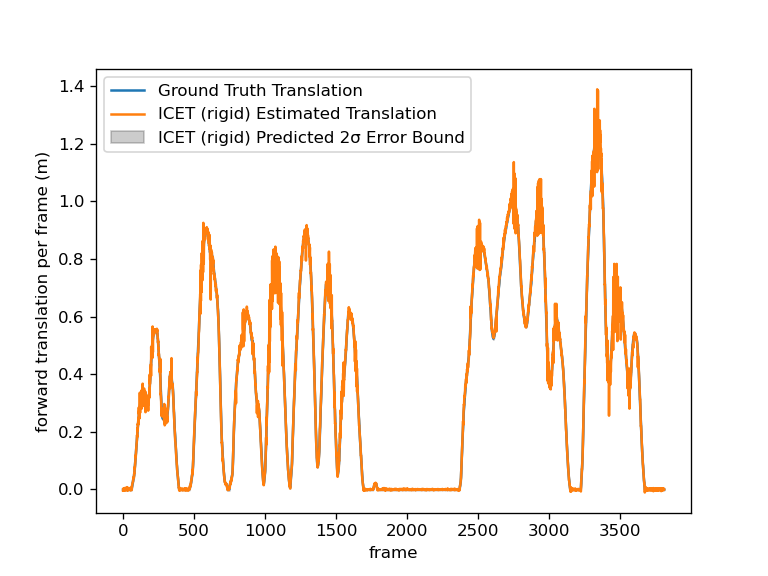

In [227]:
#load ground truth data and rigid transform ICET results
estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt")
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(estimates[:,1], label = "ICET (rigid) Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET (rigid) Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [232]:
from linear_corrector import LC
import mat4py

start_idx = 990 #start on this scan
runlen = 250
m_hat_history = np.zeros([runlen, 6])
X_hat_history = np.zeros([runlen, 6])

A0 = np.array([0., 0, 0, 0, 0, 0,
               0., 0, 0, 0, 0, 0])

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

#     #apply "ground truth" transform to point clouds
#     trans = np.array([gt[1], gt[0], gt[2]])
#     trans[0] += 0.01 #add noise to x
#     rot = R_tf(-gt[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
    
#     print("\n trans, rot GT: \n", trans, -gt[3:].numpy())

    
#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     print("\n trans, rot it.X \n", trans, -it.X[3:].numpy())
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     #run 12 State Rigid Transform + Distortion Correction
#     dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, 
#         draw = False, mnp = 25, RM = True, solver = '12_state', max_buffer = 1.0)
    
    noise = 0.05*np.random.randn()
    #seed initial alignments close to GT solution
    A0 = np.array([gt[1]+noise, 0, 0, 0, 0, 0,
                   0,           0, 0, 0, 0, 0])
    #run 12 State Rigid Transform + Distortion Correction
    dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 20, A0 = A0,
        draw = False, mnp = 50, RM = True, solver = '12_state', 
            max_buffer = 0.3)

#     A0[:6] = dc.A[:6]

#     print(dc.m_hat)
    X_hat_history[i,:] = dc.A[:6]
    m_hat_history[i,:] = dc.A[6:]


---------------------------------- SCAN IDX 990 -------------------------------------
A0:
 [-0.02025707  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0026 -0.0034 -0.0003  0.0003 -0.0004 -0.0015] 
 [ 0.0144 -0.0035 -0.0009 -0.0007  0.0003  0.002 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00018725 -0.00023698 -0.0001519  ... -0.01423498 -0.01387467
 -0.01375191]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0064 -0.0048 -0.0013  0.0003 -0.0007 -0.002 ] 
 [ 0.0168 -0.0047  0.0014 -0.0006  0.0007  0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.00021925 -0.00027471 -0.0

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0303 -0.0067  0.0006 -0.     -0.001  -0.0018] 
 [-0.0349 -0.0008 -0.002  -0.0003  0.0005  0.0045]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00045767  0.00036545  0.00063592 ...  0.03462245  0.03386341
  0.03368208]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0303 -0.0067  0.0006 -0.0001 -0.001  -0.0018] 
 [-0.0349 -0.0008 -0.002  -0.0003  0.0005  0.0045]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.00045767  0.00036544  0.00063592 ...  0.03462253  0.03386349
  0.03368215]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0303 -0.0067  0.0006 -0.0001 -0.001  -0.0018] 
 [-0.0349 -0.0008 -0.0021 -0.0003  0.0005  0.0

A0:
 [0.05322094 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0356 -0.0027  0.0034 -0.0005  0.0007  0.0003] 
 [-0.0105  0.0002 -0.0027  0.0012 -0.001   0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00013335  0.00011296  0.00019389 ...  0.01036482  0.01013783
  0.01008354]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0341 -0.0031  0.0018 -0.0002  0.0007  0.0002] 
 [-0.0114  0.0001 -0.0012  0.0009 -0.001   0.0006]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00014539  0.0001231   0.00021131 ...  0.01129776  0.01105036
  0.01099118]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=i

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0437 -0.0022 -0.001  -0.      0.0002 -0.0009] 
 [-0.0204  0.0007  0.0025  0.0001  0.0002  0.0016]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.000263    0.00033836  0.00021771 ...  0.0202285   0.01978582
  0.01967996]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0437 -0.0022 -0.001  -0.      0.0002 -0.0009] 
 [-0.0204  0.0007  0.0025  0.0001  0.0002  0.0016]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.000263    0.00033836  0.00021771 ...  0.02022862  0.01978593
  0.01968007]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0437 -0.0022 -0.001  -0.      0.0002 -0.0009] 
 [-0.0204  0.0007  0.0025  0.0001  0.0002  0.0

A0:
 [-0.06352565  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0114  0.0074 -0.0018  0.0002 -0.0002  0.0016] 
 [ 0.0472 -0.0035  0.002  -0.0003  0.0002 -0.004 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00028503  0.00059037 -0.00051955 ... -0.04662994 -0.04545757
 -0.04505646]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.016   0.0059 -0.001   0.0003 -0.0001  0.0005] 
 [ 0.0501 -0.0046 -0.0006 -0.0007  0.0001 -0.0023]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.00031081  0.00063505 -0.00054335 ... -0.04950421 -0.04825919
 -0.04783354]
num corr: 
 tf.Tensor([208], shape=(

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0282  0.0015 -0.0022  0.0001 -0.     -0.0003] 
 [ 0.0263 -0.0031  0.0043 -0.      0.0002  0.0008]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.27083063e-04  6.92147498e-05 -2.14833860e-04 ... -2.60149378e-02
 -2.53598661e-02 -2.51364977e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0282  0.0015 -0.0022  0.0001 -0.     -0.0003] 
 [ 0.0263 -0.0031  0.0043 -0.      0.0002  0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-1.27083420e-04  6.92197239e-05 -2.14837567e-04 ... -2.60156199e-02
 -2.53605264e-02 -2.51371553e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0282  0.0015 -0.0022  0.0001 -0.     -0.0003]

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0477 -0.0036 -0.0025  0.0004 -0.0004 -0.0012] 
 [ 0.0014 -0.0025  0.0056 -0.      0.0007  0.0021]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-6.67285986e-06  3.93517784e-06 -1.14285864e-05 ... -1.40980991e-03
 -1.37895711e-03 -1.37158206e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0477 -0.0036 -0.0012  0.0003 -0.0002 -0.0012] 
 [ 0.0014 -0.0024  0.0036  0.0001  0.0004  0.0021]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-6.74032266e-06  3.97654432e-06 -1.15455826e-05 ... -1.42421146e-03
 -1.39304118e-03 -1.38559056e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0477 -0.0036 -0.0025  0.0004 -0.0004 -0.001

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0868 -0.0041 -0.0033  0.0009 -0.0011  0.0017] 
 [-0.0435  0.0007  0.0059 -0.0005  0.0012 -0.0018]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00054203  0.00048025  0.00081809 ...  0.04309177  0.04215015
  0.04192524]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.087  -0.0041 -0.0033  0.0009 -0.0011  0.0017] 
 [-0.0434  0.0007  0.006  -0.0005  0.0012 -0.0019]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.0005401   0.00047935  0.00081624 ...  0.04297267  0.04203366
  0.04180939]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.087  -0.004  -0.0033  0.0009 -0.0011  0.0018] 
 [-0.0434  0.0007  0.006  -0.0005  0.0012 -0.0

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.1045 -0.003  -0.0015  0.0013 -0.0014  0.0007] 
 [-0.0588  0.0026  0.0037 -0.0012  0.0016 -0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-0.00072798  0.00099914  0.00065243 ...  0.05810241  0.05665086
  0.05615831]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.1045 -0.003  -0.0015  0.0013 -0.0014  0.0007] 
 [-0.0588  0.0026  0.0037 -0.0012  0.0016 -0.0002]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-0.00072797  0.00099913  0.00065243 ...  0.05810201  0.05665047
  0.05615792]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.1045 -0.003  -0.0015  0.0013 -0.0014  0.0007] 
 [-0.0588  0.0026  0.0037 -0.0012  0.0016 -0

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.1104 -0.0042  0.0017  0.0009  0.0003  0.0005] 
 [-0.021  -0.0014 -0.0006  0.0003 -0.001  -0.0001]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00026604  0.00022651  0.00027788 ...  0.0207784   0.02032449
  0.02021601]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.1103 -0.0042  0.001   0.001   0.0003  0.0005] 
 [-0.021  -0.0013  0.0005  0.0001 -0.0009 -0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00026624  0.00022693  0.00027835 ...  0.02080402  0.0203496
  0.02024098]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.1103 -0.0041  0.0007  0.001   0.0003  0.0005] 
 [-0.021  -0.0013  0.0011  0.0001 -0.0008 -0.00

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.1051 -0.0039 -0.      0.0005  0.0015 -0.0003] 
 [ 0.0067 -0.0029  0.0022  0.0004 -0.0015  0.0004]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 8.62067786e-05 -1.11628751e-04 -7.18933020e-05 ... -6.67156856e-03
 -6.52575434e-03 -6.49090090e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.1051 -0.004  -0.      0.0005  0.0015 -0.0003] 
 [ 0.0067 -0.0029  0.0022  0.0004 -0.0015  0.0004]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 8.59075196e-05 -1.11248269e-04 -7.16491368e-05 ... -6.64865971e-03
 -6.50334357e-03 -6.46860945e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.1051 -0.004  -0.      0.0005  0.0015 -0.000

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.1586 -0.004  -0.0025  0.0003 -0.0006  0.0006] 
 [-0.0277  0.0036  0.0028 -0.0001  0.0015 -0.0004]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 1.33827061e-04 -6.86768862e-05  2.26096651e-04 ...  2.73902568e-02
  2.67919984e-02  2.66494516e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.1585 -0.0036 -0.0037  0.0002 -0.0008  0.0006] 
 [-0.0278  0.0037  0.0063  0.0005  0.0018 -0.0004]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.34337464e-04 -6.88518111e-05  2.26916767e-04 ...  2.74837844e-02
  2.68834675e-02  2.67404374e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 1.585e-01 -3.400e-03 -6.800e-03  1.000e-04 -1.1

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1591  0.0194  0.     -0.0003 -0.0004 -0.0016] 
 [ 0.0096  0.0065 -0.0021  0.0002  0.0005  0.0007]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00012201 -0.00015969 -0.00010323 ... -0.00950954 -0.00930289
 -0.00925349]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1593  0.0208 -0.     -0.0003 -0.0004 -0.0017] 
 [ 0.0097  0.007  -0.002   0.0003  0.0005  0.0008]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00012373 -0.00016165 -0.00010446 ... -0.0096332  -0.00942393
 -0.00937389]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1593  0.022   0.     -0.0003 -0.0004 -0.0018] 
 [ 0.0098  0.0074 -0.0021  0.0002  0.0005  0

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.771e-01  1.000e-03  2.000e-04 -9.000e-04 -1.000e-04  1.000e-04] 
 [-0.0123  0.002  -0.0032  0.0005 -0.0002 -0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.0001539   0.00020684  0.00013442 ...  0.01220559  0.01193932
  0.01187599]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.731e-01 -4.000e-04  9.000e-04 -9.000e-04 -1.000e-04  2.000e-04] 
 [-0.0147  0.0018 -0.0046  0.0005 -0.0003 -0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00018382  0.00024716  0.00016062 ...  0.01458211  0.01426384
  0.01418816]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.725e-01 -1.400e-03  1.300e-03 -1.000e-03 -1.000e-04  2.00

num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [ 2.294e-01  6.000e-04 -4.700e-03  1.000e-04 -0.000e+00  0.000e+00] 
 [ 0.0362 -0.0077  0.0039 -0.0007 -0.0004 -0.0012]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.77049178e-04  8.49111420e-05 -2.97225408e-04 ... -3.58322334e-02
 -3.50513329e-02 -3.48655066e-02]
num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [ 2.294e-01  6.000e-04 -4.800e-03  1.000e-04 -0.000e+00  0.000e+00] 
 [ 0.0362 -0.0077  0.0039 -0.0007 -0.0004 -0.0012]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-1.77076955e-04  8.49527075e-05 -2.97288576e-04 ... -3.58416684e-02
 -3.50605564e-02 -3.48746813e-02]
num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [ 2.294e-01  

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.2427 -0.0156 -0.0069 -0.0003 -0.     -0.0012] 
 [-0.0368  0.0003  0.0093  0.0011  0.      0.0027]
---------------------------------- SCAN IDX 1012 -------------------------------------
A0:
 [0.25679588 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 2.465e-01 -1.000e-04 -2.900e-03 -3.000e-04  0.000e+00 -1.000e-04] 
 [-0.0061  0.0013  0.0022  0.0006  0.0002  0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 2.88146623e-05 -1.52736357e-05  4.91073803e-05 ...  6.04820245e-03
  5.89925042e-03  5.84917892e-03]
num corr: 
 tf.Tensor([198], shape=(1,), d


 new: 
 [ 0.00028599 -0.00015531  0.00049056 ...  0.06096849  0.05963912
  0.05932404]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 3.02e-01 -7.30e-03 -6.70e-03  2.00e-04 -6.00e-04 -2.00e-04] 
 [-0.0615  0.009   0.012   0.0015  0.0008  0.0029]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00028592 -0.00015581  0.00049075 ...  0.06102486  0.05969416
  0.05937879]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 3.02e-01 -7.70e-03 -6.80e-03  2.00e-04 -6.00e-04 -2.00e-04] 
 [-0.0616  0.0089  0.0121  0.0015  0.0008  0.003 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.00028585 -0.00015624  0.00049091 ...  0.06107384  0.05974196
  0.05942633]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.025e-01 -5.800e-03 -6.000e-04  2.000e-04 -7.000e-04  5.000e-04] 
 [-0.0387  0.0017  0.      0.001   0.0004  0.0001]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 1.84621167e-04 -9.28405814e-05  3.13015740e-04 ...  3.77850451e-02
  3.75410195e-02  3.73427127e-02]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.025e-01 -5.800e-03 -6.000e-04  2.000e-04 -7.000e-04  5.000e-04] 
 [-0.0387  0.0017  0.      0.001   0.0004  0.0001]
---------------------------------- SCAN IDX 1015 -------------------------------------
A0:
 [0.25035805 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.324   0.0015 -0.0061  0.0007  0.     -0.0012] 
 [-0.0148  0.0031  0.0075  0.0004 -0.0007  0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-9.54863822e-05 -1.90901147e-04  1.55436877e-04 ...  1.46779202e-02
  1.43199875e-02  1.42000145e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3242  0.0017 -0.006   0.0007  0.     -0.0013] 
 [-0.0147  0.0032  0.0075  0.0004 -0.0007  0.0019]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-9.46739794e-05 -1.89043892e-04  1.53513106e-04 ...  1.45173214e-02
  1.41633516e-02  1.40446963e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3243  0.0019 -0.0062  0.0007  0.     -0.0014]

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.423e-01 -8.900e-03  3.900e-03 -6.000e-04  1.500e-03  2.000e-04] 
 [-0.0279  0.0023 -0.0107  0.0008 -0.0021  0.0001]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-0.00034612  0.00030315  0.00051986 ...  0.02756871  0.02689308
  0.02666807]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.423e-01 -9.000e-03  3.700e-03 -5.000e-04  1.500e-03  2.000e-04] 
 [-0.0279  0.0022 -0.0109  0.0007 -0.0021  0.0001]
---------------------------------- SCAN IDX 1018 -------------------------------------
A0:
 [0.28687435 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=


 new: 
 [-7.36569561e-05 -1.53086979e-04  2.07201469e-04 ...  1.20669975e-02
  1.19892856e-02  1.19261458e-02]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.623e-01 -5.700e-03  1.500e-03  1.000e-04  2.000e-04  2.100e-03] 
 [-0.0123 -0.     -0.0163 -0.0016 -0.0021 -0.0025]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-7.29617229e-05 -1.51918377e-04  2.06238607e-04 ...  1.19957467e-02
  1.19184984e-02  1.18557341e-02]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.624e-01 -5.400e-03  1.300e-03  1.000e-04  2.000e-04  2.200e-03] 
 [-0.0122  0.0001 -0.016  -0.0016 -0.0021 -0.0027]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-7.23361216e-05 -1.50883682e-04  2.05430835e-04 ...  1.19341817e-02
  1.18573325e-02  1.17948945e-02]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32

num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.342   0.0028 -0.0005 -0.      0.0004 -0.    ] 
 [ 0.0143 -0.0017 -0.0109 -0.001  -0.0016  0.0001]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 0.00018081 -0.00023562 -0.000152   ... -0.01409375 -0.01386059
 -0.01378765]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.342   0.0029 -0.0005 -0.      0.0004 -0.    ] 
 [ 0.0143 -0.0017 -0.0109 -0.001  -0.0016  0.    ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00018088 -0.00023577 -0.0001521  ... -0.01410128 -0.013868
 -0.01379502]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.342   0.0029 -0.0005 -0.      0.0004 -0.    ] 
 [ 0.0143 -0.0016 -0.0109 -0.001  -0.0016  0. 

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 4.077e-01 -7.000e-04  3.700e-03 -2.000e-04  7.000e-04 -1.000e-04] 
 [ 0.002  -0.001  -0.0118  0.0004 -0.0013 -0.0005]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.18996920e-05  2.46980493e-05 -3.33659148e-05 ... -1.94780985e-03
 -1.93529007e-03 -1.92511809e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 4.078e-01 -6.000e-04  3.800e-03 -2.000e-04  8.000e-04 -0.000e+00] 
 [ 0.0021 -0.001  -0.0124  0.0003 -0.0014 -0.0007]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 1.24486567e-05  2.58607618e-05 -3.49885090e-05 ... -2.04125378e-03
 -2.02813374e-03 -2.01747388e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 4.08e-01 -6

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 4.349e-01 -5.600e-03  3.800e-03 -4.000e-04 -1.400e-03 -0.000e+00] 
 [-0.0208  0.0015 -0.0089  0.0003  0.0011 -0.0003]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.00012876 -0.0002619   0.00034165 ...  0.02026899  0.02013884
  0.02003311]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 4.348e-01 -5.800e-03  3.900e-03 -4.000e-04 -1.400e-03 -0.000e+00] 
 [-0.0208  0.0014 -0.009   0.0003  0.0011 -0.0002]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.0001291  -0.00026248  0.00034213 ...  0.02030452  0.02017414
  0.02006823]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 4.348e-01 -6.000e-03  3.900e-03 -4.000e-04 -1.400e-03 -1.0

A0:
 [0.58947229 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.4992 -0.0084 -0.0013 -0.0013 -0.001   0.0009] 
 [-0.0555  0.0023  0.0063  0.0017 -0.0001 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00069688 -0.00053361  0.00091422 ...  0.05420257  0.05385618
  0.05357413]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4906 -0.0102 -0.0016 -0.0011 -0.0012  0.0022] 
 [-0.0608  0.0019  0.0078  0.0015  0.0002 -0.0019]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00075092 -0.00057219  0.00101317 ...  0.05935633  0.05897691
  0.05866795]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=i

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.4909  0.0137 -0.0062 -0.0007 -0.0016 -0.0039] 
 [0.0174 0.0084 0.015  0.0009 0.0013 0.0038]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00011921  0.0002306   0.00010473 ... -0.01723816 -0.01686496
 -0.01677646]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.491   0.0149 -0.0061 -0.0007 -0.0016 -0.0038] 
 [0.0175 0.0093 0.0148 0.0009 0.0013 0.0036]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.00011938  0.00023121  0.00010485 ... -0.01730609 -0.01693151
 -0.01684268]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.4911  0.0159 -0.0062 -0.0007 -0.0016 -0.0037] 
 [0.0176 0.0101 0.0148 0.0009 0.0013 0.0034]
~~~~~~~~~~~It

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.4798  0.0078 -0.0038 -0.0019 -0.0014 -0.0006] 
 [-0.0115 -0.0413  0.0029  0.0008 -0.0005  0.0012]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-7.19449278e-05 -1.45553101e-04 -6.21829001e-05 ...  1.13739406e-02
  1.11009743e-02  1.10103360e-02]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.4799  0.0075 -0.0038 -0.0019 -0.0014 -0.0006] 
 [-0.0115 -0.0408  0.0029  0.0008 -0.0005  0.0012]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-7.20737241e-05 -1.45803802e-04 -6.22955244e-05 ...  1.13927324e-02
  1.11192701e-02  1.10284789e-02]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.4799  0.0072 -0.0038 -0.0019 -0.0014 -0.000


 new: 
 [-0.00042549 -0.00086651 -0.00066284 ...  0.06838706  0.06689234
  0.06654013]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4563 -0.023  -0.0103 -0.0038 -0.0016  0.0005] 
 [-0.069  -0.0071  0.0219  0.0038  0.0004 -0.0014]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00042513 -0.00086637 -0.0006626  ...  0.0684208   0.06692529
  0.0665729 ]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4563 -0.023  -0.0104 -0.0038 -0.0016  0.0006] 
 [-0.0689 -0.0071  0.0221  0.0038  0.0004 -0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-0.00042483 -0.00086599 -0.00066226 ...  0.0684089   0.06691366
  0.06656133]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4562 

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5654  0.002  -0.0172 -0.0018  0.      0.    ] 
 [ 0.0099 -0.0042  0.0235  0.0013  0.0004  0.0008]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-4.68674453e-05  2.14965056e-05 -7.92068235e-05 ... -9.76417877e-03
 -9.53194116e-03 -9.45535471e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5654  0.0017 -0.0172 -0.0018  0.      0.    ] 
 [ 0.0099 -0.0038  0.0235  0.0013  0.0004  0.0008]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-4.69576564e-05  2.15649653e-05 -7.93802791e-05 ... -9.78664973e-03
 -9.55384466e-03 -9.47708038e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5654  0.0014 -0.0172 -0.0018  0.      0.   


 new: 
 [-0.00038979 -0.00082723 -0.00033522 ...  0.06793828  0.06635464
  0.0658226 ]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.950e-01  1.018e-01 -3.100e-03  1.700e-03  3.000e-04  8.000e-04] 
 [-0.0959 -0.1598 -0.0002  0.0014  0.0017  0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-0.00052677 -0.00113693 -0.00045077 ...  0.09484336  0.09270181
  0.09196502]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 4.852e-01  8.140e-02 -3.500e-03  1.600e-03  3.000e-04 -4.000e-03] 
 [-0.1016 -0.1711  0.0012  0.0016  0.0018  0.0099]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00063866 -0.00128647 -0.00055794 ...  0.10058815  0.09829239
  0.09750775]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.24e-01 -4.82e-02  1.62e-02 -2.00e-04 -1.70e-03 -6.70e-03] 
 [ 0.0394 -0.0219 -0.0175  0.0049  0.0011  0.0058]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 0.00028575  0.00053775  0.00025297 ... -0.03854679 -0.03830099
 -0.03809953]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.225e-01 -5.300e-02  1.660e-02 -3.000e-04 -1.700e-03 -7.400e-03] 
 [ 0.0385 -0.0232 -0.018   0.005   0.0011  0.0068]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00028353  0.00052937  0.00025152 ... -0.03760008 -0.03736023
 -0.03716361]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.209e-01 -5.760e-02  1.740e-02 -4.000e-04 -1.700e-03 -8.100e-03

A0:
 [0.55122077 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [ 0.5666  0.0054 -0.0149 -0.0043 -0.002  -0.    ] 
 [ 0.0087  0.0005  0.0355  0.002   0.0035 -0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 5.20449413e-05  1.07672759e-04  4.44733182e-05 ... -8.63619337e-03
 -8.43064112e-03 -8.36284790e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 5.702e-01  1.400e-03 -1.770e-02 -3.400e-03 -2.000e-03 -5.000e-04] 
 [ 0.0109 -0.0019  0.0378 -0.0005  0.0041 -0.0015]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 6.56819202e-05  1.34934894e-04  5.63137282e-05 ... -1.07521789e-02
 -1.04961916e-02

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5721 -0.0091 -0.0129 -0.0044  0.0009 -0.0018] 
 [-0.0135 -0.001   0.0229  0.0009 -0.0006  0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-8.54971254e-05 -1.71747035e-04 -7.38869915e-05 ...  1.32115521e-02
  1.31274670e-02  1.30584534e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5715 -0.0091 -0.0116 -0.0044  0.001  -0.002 ] 
 [-0.0138 -0.0009  0.0207  0.0008 -0.0009  0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-8.77449361e-05 -1.75784413e-04 -7.58925131e-05 ...  1.34850240e-02
  1.33991923e-02  1.33287442e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5721 -0.0091 -0.0131 -0.0043  0.0008 -0.0018]

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.735e-01 -2.160e-02 -1.630e-02 -3.200e-03 -1.000e-04 -5.100e-03] 
 [-0.0068 -0.0036  0.0221  0.0025  0.001   0.0076]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-4.78410465e-05 -9.13211403e-05 -7.12287538e-05 ...  6.66258419e-03
  6.62015919e-03  6.58534040e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.728e-01 -2.240e-02 -1.620e-02 -3.200e-03 -1.000e-04 -5.400e-03] 
 [-0.0071 -0.0037  0.0221  0.0025  0.001   0.008 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-5.01927280e-05 -9.55440786e-05 -7.45868360e-05 ...  6.94893345e-03
  6.90468051e-03  6.86836152e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.722e-01

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5616 -0.0107 -0.0049  0.0012  0.0036 -0.0018] 
 [-0.004  -0.0036 -0.0078  0.0014 -0.0032  0.0014]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.50023836e-05 -5.06825736e-05 -2.18150886e-05 ...  3.94860778e-03
  3.92353462e-03  3.90298546e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5614 -0.011  -0.0049  0.0013  0.0036 -0.002 ] 
 [-0.0042 -0.0036 -0.008   0.0014 -0.0033  0.0016]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-2.59392690e-05 -5.24757982e-05 -2.26460350e-05 ...  4.08015568e-03
  4.05424570e-03  4.03301119e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5611 -0.0111 -0.0048  0.0013  0.0036 -0.0021]

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6811 -0.0035  0.0064  0.0032  0.0051 -0.0051] 
 [ 0.0375 -0.014  -0.0156  0.0011 -0.0033  0.0021]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00024083  0.00047892  0.00037072 ... -0.03662839 -0.03639612
 -0.03620642]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6811 -0.0035  0.0064  0.0032  0.0051 -0.0051] 
 [ 0.0375 -0.014  -0.0156  0.0011 -0.0033  0.0021]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00024078  0.00047874  0.0003706  ... -0.03660945 -0.0363773
 -0.0361877 ]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6811 -0.0035  0.0064  0.0032  0.0051 -0.0051] 
 [ 0.0375 -0.014  -0.0156  0.0011 -0.0033  0.

A0:
 [0.69852638 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.81e-01  2.00e-04 -9.70e-03 -1.60e-03 -7.00e-04 -1.00e-04] 
 [-0.0094  0.0024  0.0202  0.0003  0.0023 -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-5.83327426e-05 -1.18040250e-04  1.53401300e-04 ...  9.21552756e-03
  9.15700723e-03  9.10947046e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.792e-01 -1.400e-03 -1.190e-02 -1.800e-03 -1.200e-03 -2.000e-04] 
 [-0.0105  0.0019  0.0272  0.0007  0.0033 -0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-6.49857743e-05 -1.31387216e-04  1.70409742e-04 ...  1.02465021e-02
  1.

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.628   0.0091 -0.0128 -0.0031 -0.0007 -0.001 ] 
 [-0.015   0.0066  0.022   0.001   0.0018  0.0028]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-9.42350261e-05 -1.89188960e-04  2.43169783e-04 ...  1.46701380e-02
  1.45769128e-02  1.45012737e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.628   0.009  -0.0128 -0.0031 -0.0007 -0.001 ] 
 [-0.015   0.0066  0.022   0.001   0.0018  0.0027]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-9.40976252e-05 -1.88927385e-04  2.42866590e-04 ...  1.46509786e-02
  1.45578769e-02  1.44823357e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.628   0.009  -0.0129 -0.0031 -0.0007 -0.001 ]

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6482 -0.2353  0.0103 -0.0038  0.0036 -0.0214] 
 [ 0.0141 -0.069  -0.0251  0.0049 -0.0046  0.0241]
---------------------------------- SCAN IDX 1045 -------------------------------------
A0:
 [0.62867409 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6501 -0.0327 -0.0016  0.0034  0.0011 -0.0066] 
 [ 0.0153 -0.0136 -0.0012  0.0016  0.0005  0.008 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00010734  0.0002045  -0.00023688 ... -0.0151538  -0.01479358
 -0.01467632]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], s

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.637e-01 -1.950e-02  3.500e-03  5.300e-03 -2.400e-03 -2.000e-04] 
 [ 0.0095 -0.0115 -0.0115 -0.0004  0.0026 -0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 5.81643858e-05  1.18309857e-04 -1.55753116e-04 ... -9.29625665e-03
 -9.23725324e-03 -9.18948448e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.636e-01 -2.010e-02  3.500e-03  5.300e-03 -2.400e-03 -2.000e-04] 
 [ 0.0095 -0.0117 -0.0115 -0.0003  0.0026 -0.001 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 5.82581519e-05  1.18430653e-04 -1.55733655e-04 ... -9.29973831e-03
 -9.24070965e-03 -9.19292035e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.636e-01 -

num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 0.7452  0.1926 -0.0062  0.005  -0.0021 -0.0143] 
 [ 0.0778  0.1067  0.0164 -0.0018  0.0019 -0.0011]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 0.00061577 -0.0011485  -0.00070517 ... -0.07573233 -0.07525735
 -0.07487585]
num corr: 
 tf.Tensor([183], shape=(1,), dtype=int32)
LUT tf.Tensor([183   3   3], shape=(3,), dtype=int32)

 residuals (549, 1)

 delta_A
 (12,)
A: 
 [ 0.6838  0.0359 -0.0077  0.0055 -0.0022 -0.0059] 
 [ 0.0357  0.0209  0.0194 -0.0023  0.002   0.0042]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00024688 -0.00055904 -0.00035288 ... -0.03490103 -0.03468016
 -0.03450165]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.6734 -0.0008 -0.0052  0.0041 -0.0022 -0.0032] 
 [ 0.0282  0.0001  0.0169 -0.0006  0.0021  0

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6501 -0.004  -0.028  -0.0032 -0.0062 -0.0009] 
 [-0.0494  0.005   0.0619  0.0025  0.006   0.0031]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00031342 -0.00062482 -0.00027057 ...  0.0483143   0.04800845
  0.04775992]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6502 -0.0036 -0.0281 -0.0032 -0.0062 -0.0009] 
 [-0.0494  0.0053  0.062   0.0025  0.006   0.003 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00031289 -0.00062385 -0.00027009 ...  0.04824836  0.04794294
  0.04769475]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6502 -0.0034 -0.0279 -0.0032 -0.0062 -0.0009] 
 [-0.0494  0.0054  0.0618  0.0025  0.006   0.0

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.6408 -0.0265 -0.0034 -0.0069 -0.001  -0.0624] 
 [-0.0879  0.054   0.0026  0.0061 -0.002   0.1062]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-0.00143934 -0.00201036 -0.00136541 ...  0.08735939  0.086799
  0.08634214]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6345 -0.0318 -0.0021 -0.007  -0.0009 -0.0657] 
 [-0.0926  0.0551  0.0004  0.0063 -0.0022  0.1116]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-0.00156708 -0.00216912 -0.00148878 ...  0.092042    0.09145101
  0.09096912]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6277 -0.0372 -0.0009 -0.0072 -0.0008 -0.0687] 
 [-0.0975  0.0561 -0.0016  0.0065 -0.0023  0.1

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6823 -0.0118  0.0056  0.0058  0.0062  0.    ] 
 [-0.0361 -0.0025 -0.0245 -0.0026 -0.0043 -0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00021237 -0.00043951 -0.00018506 ...  0.03576274  0.0349288
  0.03465575]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6825 -0.0116  0.0055  0.0058  0.0062  0.    ] 
 [-0.036  -0.0024 -0.0244 -0.0026 -0.0043 -0.0013]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00021155 -0.00043792 -0.00018435 ...  0.03563926  0.03480831
  0.03453621]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6826 -0.0114  0.0056  0.0058  0.0062  0.    ] 
 [-0.0359 -0.0023 -0.0246 -0.0027 -0.0044 -0.00

A: 
 [ 0.7712 -0.0167  0.0034  0.0046 -0.001  -0.0015] 
 [ 0.0345 -0.0144 -0.0008  0.      0.0046  0.0029]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 0.00022018  0.00043679 -0.00055456 ... -0.03372542 -0.03351242
 -0.03333919]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7712 -0.0168  0.0034  0.0046 -0.001  -0.0015] 
 [ 0.0345 -0.0145 -0.0008  0.      0.0046  0.0029]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 0.00022005  0.00043656 -0.00055436 ... -0.03371083 -0.03349792
 -0.03332477]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7711 -0.0169  0.0034  0.0046 -0.001  -0.0015] 
 [ 0.0345 -0.0145 -0.0008  0.      0.0046  0.0029]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00021984  0.00043616 -0.00055384 ... -0.03367965 -0.03346693
 -0.03329394]
num corr: 
 tf.

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.393e-01 -4.000e-03 -1.560e-02 -3.800e-03 -3.600e-03  5.000e-04] 
 [-0.0083 -0.001   0.032   0.0015  0.0033 -0.0008]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-4.83941238e-05 -1.00325718e-04 -4.11256057e-05 ...  8.09645925e-03
  8.04524096e-03  8.00358245e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.389e-01 -5.100e-03 -1.540e-02 -3.800e-03 -3.600e-03  4.000e-04] 
 [-0.0086 -0.0013  0.0319  0.0016  0.0033 -0.0007]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-5.02936931e-05 -1.04149739e-04 -4.27623976e-05 ...  8.39509652e-03
  8.34198429e-03  8.29878438e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.386e-01 -

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7589 -0.0308 -0.0234 -0.0029 -0.0012  0.0026] 
 [-0.0204  0.0502  0.0398  0.0008  0.0007 -0.0033]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.00012231 -0.0002507  -0.00010537 ...  0.0199674   0.01984111
  0.0197381 ]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7588 -0.032  -0.0235 -0.0029 -0.0013  0.0025] 
 [-0.0201  0.0518  0.0399  0.0008  0.0007 -0.0033]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-0.00012009 -0.00024601 -0.00010348 ...  0.01958295  0.01945909
  0.01935805]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7587 -0.0331 -0.0234 -0.0029 -0.0013  0.0025] 
 [-0.0197  0.0533  0.0399  0.0008  0.0007 -0

A0:
 [0.76496893 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.662e-01 -1.190e-02  7.400e-03  1.600e-03  5.300e-03 -2.000e-04] 
 [ 0.001  -0.008  -0.0132  0.0022 -0.0029 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.19138004e-06  1.26613076e-05  5.37005394e-06 ... -1.00950427e-03
 -1.00312330e-03 -9.97928123e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 7.648e-01 -1.270e-02  1.300e-03  1.900e-03  5.400e-03  4.000e-04] 
 [ 0.     -0.0084 -0.0074  0.0027 -0.0029 -0.001 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 2.09753049e-07  4.32363121e-07  1.81545132e-07 ... -3.47307770e-0


 new: 
 [-0.00041275 -0.00084417  0.00112192 ...  0.06707902  0.06665422
  0.06630925]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.688  -0.0468  0.0034  0.0011  0.0023  0.0012] 
 [-0.0693  0.0031 -0.0043  0.0032  0.0017  0.003 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00041761 -0.00085387  0.00113363 ...  0.06780864  0.06737915
  0.06703035]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6873 -0.0483  0.0035  0.0011  0.0023  0.0012] 
 [-0.0698  0.0025 -0.0042  0.0032  0.0017  0.0032]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.00042105 -0.00086044  0.00114085 ...  0.06827859  0.06784608
  0.0674948 ]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.6867 

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.281e-01 -4.400e-03  2.100e-03 -8.000e-04 -1.700e-03 -1.000e-03] 
 [ 0.0053 -0.0032  0.0014  0.0024  0.0037  0.0021]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.73515863e-05  2.97145220e-05 -8.50505753e-05 ... -5.20955596e-03
 -5.17669115e-03 -5.15013315e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.281e-01 -4.400e-03  2.100e-03 -8.000e-04 -1.700e-03 -1.000e-03] 
 [ 0.0053 -0.0032  0.0014  0.0024  0.0037  0.0021]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 6.72744202e-05  2.96783388e-05 -8.49610029e-05 ... -5.20385776e-03
 -5.17102922e-03 -5.14449996e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.281e-01

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.857e-01 -1.055e-01  1.300e-03 -2.600e-03 -3.000e-04 -3.200e-03] 
 [-0.0052  0.1148  0.0084  0.0021  0.0007  0.0045]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.64762993e-05 -6.93300741e-05 -5.43775407e-05 ...  5.06692918e-03
  5.03469548e-03  5.00854790e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.869e-01 -1.281e-01  2.200e-03 -2.700e-03 -3.000e-04 -4.100e-03] 
 [-0.0049  0.1453  0.0073  0.0023  0.0007  0.0054]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-3.51176232e-05 -6.60582447e-05 -5.19196918e-05 ...  4.75511321e-03
  4.72482945e-03  4.70024624e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.840e-01 -

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.128e-01 -2.260e-02 -4.800e-03  9.000e-04  1.000e-04  7.000e-04] 
 [ 0.0074 -0.0125  0.0031  0.0007 -0.0009 -0.0001]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-3.06997887e-05  1.88451244e-05 -5.50203654e-05 ... -7.32525990e-03
 -7.15232541e-03 -7.09631932e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.128e-01 -2.260e-02 -4.700e-03  9.000e-04  1.000e-04  7.000e-04] 
 [ 0.0074 -0.0126  0.003   0.0007 -0.0009 -0.0001]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-3.06447158e-05  1.88643472e-05 -5.49480495e-05 ... -7.31991181e-03
 -7.14710138e-03 -7.09113617e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.127e-01

A0:
 [0.73003137 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.323e-01 -3.130e-02  2.100e-03  1.300e-03  1.000e-04  2.200e-03] 
 [ 0.0007 -0.0151 -0.0015  0.0004  0.0005  0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.24733279e-06  1.52542694e-06 -5.60647751e-06 ... -6.96298161e-04
 -6.91883374e-04 -6.88308358e-04]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.722  -0.0423  0.0025  0.0009 -0.      0.0032] 
 [-0.0065 -0.0187  0.0005  0.0013  0.0007  0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 2.98018982e-05 -1.39586193e-05  5.16312566e-05 ...  6.37429049e-03
  6.33383961e-03

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.414e-01  5.000e-04  2.600e-03 -9.000e-04  1.400e-03 -3.500e-03] 
 [ 0.0173 -0.0025  0.0003  0.0015 -0.0016  0.0047]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-6.52739000e-05  5.04243817e-05 -1.21046606e-04 ... -1.69313503e-02
 -1.68241001e-02 -1.67373306e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.408e-01 -3.000e-04  2.600e-03 -1.000e-03  1.400e-03 -3.700e-03] 
 [ 0.0169 -0.0027  0.0005  0.0016 -0.0016  0.0051]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-6.29726311e-05  5.00901187e-05 -1.17502720e-04 ... -1.65434887e-02
 -1.64386835e-02 -1.63538929e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7403 -0.0

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7377 -0.0712  0.0109 -0.0058 -0.0043 -0.0113] 
 [-0.0169 -0.0293  0.0056  0.0055  0.0061  0.0181]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 2.73438974e-05 -8.68638444e-05  8.57014296e-05 ...  1.65921161e-02
  1.64864890e-02  1.64009548e-02]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7376 -0.0714  0.011  -0.0058 -0.0043 -0.0113] 
 [-0.017  -0.0294  0.0055  0.0055  0.006   0.0181]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 2.74536706e-05 -8.73524761e-05  8.61292224e-05 ...  1.66786021e-02
  1.65724226e-02  1.64864397e-02]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7375 -0.0716  0.011  -0.0058 -0.0043 -0.011


 new: 
 [-0.00050507 -0.00043711  0.00089885 ...  0.08351947  0.0815662
  0.08093466]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.362e-01 -1.940e-02 -1.380e-02 -2.000e-04 -2.900e-03 -0.000e+00] 
 [-0.0848  0.0038  0.0177  0.0017 -0.0018  0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00051065 -0.00044232  0.0009005  ...  0.08394987  0.08198561
  0.08135068]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.357e-01 -2.010e-02 -1.380e-02 -2.000e-04 -2.900e-03 -2.000e-04] 
 [-0.0851  0.0036  0.0177  0.0017 -0.0018  0.0012]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00051525 -0.00044665  0.00090137 ...  0.08427379  0.0823013
  0.08166383]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 


 new: 
 [ 0.00029276 -0.00051475 -0.0008971  ... -0.04819282 -0.0470443
 -0.0466768 ]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 8.213e-01 -5.940e-02 -5.000e-04 -4.000e-04  5.300e-03  2.100e-03] 
 [ 0.0489  0.0844 -0.0042  0.004  -0.0082 -0.0053]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00029486 -0.00051599 -0.00090021 ... -0.04839847 -0.04724312
 -0.04687392]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 8.213e-01 -6.300e-02 -4.000e-04 -5.000e-04  5.300e-03  2.000e-03] 
 [ 0.0491  0.09   -0.0043  0.0041 -0.0082 -0.0052]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00029651 -0.00051665 -0.00090228 ... -0.04854451 -0.04738376
 -0.04701332]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (59

A0:
 [0.69302499 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.922e-01  5.000e-04 -1.100e-03 -3.000e-03  2.800e-03  5.000e-04] 
 [-0.0006  0.0005  0.001   0.0018 -0.0024 -0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.55714379e-06  6.39960733e-06  1.10845063e-05 ...  5.95071483e-04
  5.82218524e-04  5.79193552e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6941 -0.0007 -0.0033 -0.0029  0.0029  0.0007] 
 [ 0.0008 -0.0008  0.0004  0.0016 -0.0027 -0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 4.47572588e-06 -8.12620954e-06 -1.40567537e-05 ... -7.53220480e-04
 -7.36950039e-04

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.499e-01 -6.000e-04  1.070e-02 -3.600e-03  5.100e-03  1.400e-03] 
 [-0.0234  0.0051 -0.0123  0.0018 -0.0029 -0.0005]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00014101 -0.00012139 -0.00022081 ...  0.02319756  0.02265798
  0.0224829 ]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.498e-01 -6.000e-04  1.070e-02 -3.600e-03  5.100e-03  1.400e-03] 
 [-0.0235  0.005  -0.0123  0.0018 -0.0029 -0.0005]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.0001411  -0.00012146 -0.00022094 ...  0.02321029  0.02267041
  0.02249524]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.498e-01 -6.000e-04  1.070e-02 -3.600e-03  5.100e-03  1.40

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.774e-01 -3.170e-02 -3.000e-04 -1.000e-03  2.100e-03  1.300e-03] 
 [-0.0386 -0.01    0.0005  0.0003  0.0013  0.0003]
---------------------------------- SCAN IDX 1075 -------------------------------------
A0:
 [0.80696708 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7848 -0.0032 -0.0095  0.0013 -0.0026  0.0013] 
 [-0.0165 -0.0003  0.0116  0.0001  0.0051 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 7.33681254e-05 -3.65729926e-05  1.26679073e-04 ...  1.61107465e-02
  1.60089918e-02  1.59265004e-02]
num corr: 
 tf.Tensor([201], shape=(1,), d

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.74   -0.0085 -0.0063  0.003   0.0025 -0.0046] 
 [ 0.018  -0.0118 -0.0088 -0.0008 -0.0043  0.0054]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00011775  0.00023174  0.00010364 ... -0.01758844 -0.01747701
 -0.01738657]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.74   -0.0091 -0.0062  0.003   0.0025 -0.0046] 
 [ 0.018  -0.011  -0.009  -0.0008 -0.0043  0.0054]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.00011797  0.00023206  0.00010384 ... -0.01760584 -0.0174943
 -0.01740377]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7401 -0.0097 -0.0061  0.003   0.0025 -0.0046] 
 [ 0.0181 -0.0102 -0.0092 -0.0008 -0.0044  0.00

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.686e-01 -2.320e-02 -5.600e-03  2.100e-03  4.700e-03  2.000e-04] 
 [-0.039  -0.0123  0.011   0.0034 -0.0026  0.0007]
---------------------------------- SCAN IDX 1078 -------------------------------------
A0:
 [0.70506448 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.331e-01 -3.250e-02  3.800e-03 -8.000e-04 -9.000e-04  2.000e-04] 
 [ 0.0229  0.0346 -0.0001 -0.0009  0.0048 -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-8.92124535e-05  6.39154964e-05 -1.65094422e-04 ... -2.24073046e-02
 -2.22650563e-02 -2.21501399e-02]
num corr: 
 tf.Tensor([1

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.7355 -0.0025 -0.     -0.0031 -0.0068  0.0033] 
 [-0.0756  0.008   0.007  -0.001   0.007  -0.0031]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00091706 -0.00037615 -0.000696   ...  0.07387789  0.07341137
  0.07303512]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.354e-01 -2.800e-03  4.000e-04 -3.200e-03 -6.800e-03  3.500e-03] 
 [-0.0757  0.0078  0.0072 -0.0008  0.0071 -0.0033]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00091604 -0.00037465 -0.00069476 ...  0.07393738  0.07347048
  0.07309392]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.354e-01 -2.900e-03  6.000e-04 -3.200e-03 -6.900e-03  3.600e-03] 
 [-0.0757 

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.8351 -0.4517  0.0105 -0.0054  0.0009 -0.0039] 
 [ 0.0104  0.6773 -0.0295  0.0051 -0.0065  0.0035]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 8.41944476e-05  7.51797912e-05  1.19779960e-04 ... -1.04206843e-02
 -1.01737890e-02 -1.01197478e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.8353 -0.4614  0.0111 -0.0056  0.0009 -0.0042] 
 [ 0.0101  0.691  -0.0304  0.0053 -0.0066  0.0039]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 8.25387992e-05  7.37711715e-05  1.17094706e-04 ... -1.01208670e-02
 -9.88059141e-03 -9.82806938e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.8351 -0.4687  0.0123 -0.0057  0.0009 -0.004

A0:
 [0.74117756 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7574 -0.0095 -0.0117  0.0038 -0.004   0.0009] 
 [ 0.01   -0.0064  0.0134 -0.0006  0.0042  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.21350273e-05  5.43243270e-05  9.67561004e-05 ... -9.81073007e-03
 -9.74861827e-03 -9.69823725e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.565e-01 -8.200e-03 -3.100e-03  2.600e-03 -4.000e-03  6.000e-04] 
 [ 0.0097 -0.0055  0.0077  0.0011  0.0039  0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 6.04331346e-05  5.28343455e-05  9.38023722e-05 ... -9.46912632e-03
 -9.40916544e-03

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.21e-01 -6.37e-02  8.70e-03  1.60e-03  1.00e-04 -3.80e-03] 
 [-0.0217  0.0552 -0.018   0.0004 -0.0037  0.0054]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00014994 -0.00013228  0.00021077 ...  0.02149222  0.02097566
  0.02080981]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.202e-01 -6.860e-02  9.300e-03  1.500e-03  1.000e-04 -4.300e-03] 
 [-0.0223  0.0539 -0.0187  0.0006 -0.0038  0.0061]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.00015627 -0.00013808  0.0002149  ...  0.02211897  0.0215861
  0.02141531]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.194e-01 -7.320e-02  1.000e-02  1.400e-03  1.000e-04 -4.700e-03] 

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.692e-01 -5.800e-03  2.000e-03 -1.600e-03  1.000e-03 -5.000e-04] 
 [-0.0261  0.0024  0.025   0.0035 -0.      0.0002]
---------------------------------- SCAN IDX 1085 -------------------------------------
A0:
 [0.79322517 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.519e-01  6.300e-03 -1.270e-02 -2.700e-03 -3.500e-03 -2.000e-04] 
 [-0.0247  0.0081  0.03    0.0011  0.0046  0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.06209053e-04 -5.97529779e-05  1.86133269e-04 ...  2.41124737e-02
  2.39600117e-02  2.38359176e-02]
num corr: 
 tf.Tensor([2

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.695  -0.1968 -0.0193 -0.0041 -0.0037 -0.0147] 
 [-0.0296 -0.0799  0.0079  0.0018 -0.0023  0.0242]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00026082  0.0002317   0.00047191 ...  0.02907134  0.0288852
  0.0287323 ]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6946 -0.1976 -0.0193 -0.0042 -0.0037 -0.015 ] 
 [-0.0299 -0.0802  0.0088  0.002  -0.0024  0.0246]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.00026451  0.00023268  0.00047521 ...  0.02934712  0.0291592
  0.02900483]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6941 -0.1998 -0.0196 -0.0042 -0.0038 -0.0152] 
 [-0.0301 -0.0811  0.0094  0.002  -0.0023  0.024

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.431e-01 -1.260e-02 -1.820e-02 -1.300e-03  6.000e-03  3.000e-04] 
 [-0.0102 -0.0062 -0.0011  0.0001 -0.0098  0.0001]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-6.10969392e-05 -5.27274329e-05  1.08208413e-04 ...  1.00887377e-02
  9.85064113e-03  9.77276288e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.431e-01 -1.260e-02 -1.820e-02 -1.300e-03  6.000e-03  3.000e-04] 
 [-0.0102 -0.0062 -0.0011  0.0001 -0.0098  0.0001]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-6.10954054e-05 -5.27261850e-05  1.08204084e-04 ...  1.00883885e-02
  9.85029953e-03  9.77242398e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.431e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.888e-01 -1.020e-02  8.300e-03  2.000e-04  5.900e-03  6.000e-04] 
 [-0.02   -0.0023 -0.0041  0.002   0.0037 -0.0004]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-0.00012353 -0.00010734 -0.00019168 ...  0.01958265  0.01945858
  0.01935797]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.885e-01 -1.210e-02  8.300e-03  2.000e-04  5.900e-03  6.000e-04] 
 [-0.0203 -0.0032 -0.0031  0.0021  0.0038 -0.0003]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.0001252  -0.00010883 -0.00019421 ...  0.01982536  0.01969974
  0.01959786]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.883e-01 -1.360e-02  8.200e-03  2.000e-04  5.800e-03  5.00

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.061e-01 -1.730e-02  1.080e-02  2.000e-04 -6.500e-03 -2.000e-04] 
 [-0.0089 -0.0027  0.0106  0.0026  0.0129  0.0019]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 3.79901655e-05 -2.09032506e-05  6.70915428e-05 ...  8.80435897e-03
  8.59894094e-03  8.53258900e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.061e-01 -1.730e-02  1.080e-02  2.000e-04 -6.500e-03 -2.000e-04] 
 [-0.0089 -0.0027  0.0106  0.0026  0.0129  0.0019]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 3.79198058e-05 -2.08634046e-05  6.69666334e-05 ...  8.78788369e-03
  8.58284951e-03  8.51662226e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.061e-01 

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.462e-01 -1.290e-02  4.200e-03  2.000e-04 -7.300e-03 -1.500e-03] 
 [-0.0183 -0.0032 -0.0001 -0.0006  0.0055  0.0015]
---------------------------------- SCAN IDX 1092 -------------------------------------
A0:
 [0.8034429 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.002e-01 -2.430e-02 -1.320e-02 -1.300e-03 -4.800e-03 -3.000e-04] 
 [-0.0629  0.0104  0.014   0.0004 -0.001  -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00025179 -0.00016931  0.00046089 ...  0.06227781  0.06081068
  0.06033627]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT t


 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7825 -0.011  -0.0026 -0.0011  0.0023  0.    ] 
 [ 0.0174 -0.0102  0.007   0.0022 -0.0049  0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-7.24258934e-05  4.42239805e-05 -1.29442037e-04 ... -1.69989799e-02
 -1.68914449e-02 -1.68039409e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7819 -0.0126 -0.0027 -0.0011  0.0023  0.    ] 
 [ 0.0169 -0.0108  0.0071  0.0021 -0.0048  0.0003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-7.00759082e-05  4.32533741e-05 -1.25537509e-04 ... -1.65126872e-02
 -1.64082215e-02 -1.63232086e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7817 -0.0141 -0.0027 -0.0011  0.0023  0.    ] 
 [ 0.0167 -0.0114  0.0072  0.0022 -0.0048  0.0004]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-6.9159969

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.472e-01 -3.610e-02 -7.500e-03  2.000e-04  5.000e-04  1.000e-03] 
 [-0.026   0.0525  0.0187  0.0018 -0.0007 -0.001 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-0.00015271 -0.00031954 -0.00013176 ...  0.02539742  0.02523651
  0.0251053 ]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.472e-01 -3.730e-02 -7.500e-03  2.000e-04  5.000e-04  1.000e-03] 
 [-0.0264  0.0532  0.0187  0.0018 -0.0007 -0.001 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-0.00015545 -0.00032514 -0.00013414 ...  0.02583861  0.0256749
  0.0255414 ]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.476e-01 -3.840e-02 -7.100e-03  2.000e-04  5.000e-04  1.0

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7055  0.0054  0.0015 -0.0011  0.0029  0.0011] 
 [ 0.0214 -0.0003 -0.0043  0.0015 -0.005  -0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00012744  0.0002659   0.00010995 ... -0.02086979 -0.02073751
 -0.02062957]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 7.041e-01  2.000e-03 -3.600e-03 -7.000e-04  3.100e-03 -0.000e+00] 
 [ 0.0201 -0.0015 -0.0018  0.001  -0.0053  0.    ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.0001237   0.00025393  0.00010728 ... -0.01963884 -0.01951432
 -0.01941272]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 7.025e-01 -8.000e-04 -3.200e-03 -7.000e-04  3.200e-03 -8.000e-04] 
 [ 0.0187 

A: 
 [ 0.7329  0.0031  0.001  -0.0014  0.006  -0.0008] 
 [ 0.0007  0.0021 -0.0161  0.0014 -0.0062  0.001 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 4.43224668e-06  9.01535265e-06  3.85475435e-06 ... -6.90239428e-04
 -6.85864676e-04 -6.82298485e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7329  0.0032  0.001  -0.0014  0.006  -0.0008] 
 [ 0.0007  0.0021 -0.016   0.0014 -0.0062  0.001 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 4.66843468e-06  9.49605057e-06  4.06016339e-06 ... -7.27046072e-04
 -7.22438036e-04 -7.18681810e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7329  0.0033  0.001  -0.0014  0.006  -0.0008] 
 [ 0.0008  0.0022 -0.016   0.0014 -0.0062  0.001 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 4.77155864e-06  9.70593202e-06  4.14985642e-06

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.016e-01 -3.000e-04  2.100e-03 -3.000e-04  1.100e-03 -1.000e-03] 
 [ 0.0264 -0.0031  0.002   0.0013  0.0028  0.0011]
---------------------------------- SCAN IDX 1099 -------------------------------------
A0:
 [0.64674819 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.548e-01 -7.610e-02  5.000e-04  5.000e-04 -1.300e-03  3.100e-03] 
 [ 0.0149  0.0893  0.0001  0.0002  0.0039 -0.0056]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 8.74708437e-05  7.55652047e-05  1.37870947e-04 ... -1.45742843e-02
 -1.44816521e-02 -1.44064408e-02]
num corr: 
 tf.Tensor([2

A: 
 [ 0.763  -0.1855  0.0202 -0.0008 -0.0017 -0.002 ] 
 [ 5.330e-02  2.325e-01 -2.890e-02  1.600e-03  6.000e-04 -2.000e-04]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.0003595   0.0003165   0.00053857 ... -0.05212039 -0.05178794
 -0.05151719]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7629 -0.2179  0.0207 -0.0009 -0.0017 -0.0016] 
 [ 0.0559  0.2746 -0.029   0.0017  0.0005 -0.001 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 0.00037967  0.00033456  0.00056739 ... -0.05470067 -0.05435134
 -0.05406654]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7631 -0.2474  0.0209 -0.001  -0.0017 -0.0011] 
 [ 0.0586  0.3136 -0.029   0.0019  0.0005 -0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00039882  0.00035152  0.00059548 ... -0.05737029 -0.05700352
 -0.05670422]


LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.712e-01 -1.500e-03  1.600e-03 -2.000e-04 -2.400e-03 -5.000e-04] 
 [ 0.0396 -0.0076  0.0131  0.0013  0.002   0.0002]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00024429  0.00049218  0.00021213 ... -0.03871655 -0.03847048
 -0.03827104]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.712e-01 -1.500e-03  1.600e-03 -2.000e-04 -2.400e-03 -5.000e-04] 
 [ 0.0396 -0.0076  0.0131  0.0013  0.002   0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 0.0002442   0.00049199  0.00021205 ... -0.03870221 -0.03845623
 -0.03825686]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.712e-01 -1.500e-03  1.600e-03 -2.000e-04 -2.400e-03 -5.000e-04] 
 [ 0.0396 -0.0076  0.0131  0.0013  0.002   0

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.985e-01 -4.690e-02 -4.500e-03 -4.000e-04 -2.600e-03  2.000e-03] 
 [ 0.0974  0.0703 -0.0009  0.0008  0.0008 -0.0037]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00055669  0.00116468  0.00047883 ... -0.09636848 -0.09405512
 -0.09330895]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.985e-01 -5.710e-02 -5.200e-03 -4.000e-04 -2.600e-03  2.300e-03] 
 [ 0.0979  0.0837  0.0003  0.0008  0.0009 -0.0041]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.0005582   0.001169    0.00048004 ... -0.09679494 -0.09446079
 -0.09371075]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.987e-01 -6.210e-02 -5.000e-03 -4.000e-04 -2.600e-03  2.40

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6902 -0.1081  0.0012  0.0019  0.0029  0.001 ] 
 [ 0.007   0.121  -0.0149 -0.001  -0.0063 -0.003 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-2.40397422e-05  2.38134755e-05 -4.87927817e-05 ... -6.87860676e-03
 -6.79540733e-03 -6.75975966e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6895 -0.1138  0.0012  0.002   0.0029  0.0009] 
 [ 0.0081  0.1278 -0.0151 -0.0011 -0.0063 -0.0029]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-2.71908816e-05  2.81113485e-05 -5.59120303e-05 ... -7.94589197e-03
 -7.84974693e-03 -7.80855018e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6887 -0.1196  0.001   0.002   0.0029  0.000

A0:
 [0.6671983 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6728 -0.0122 -0.003   0.0037 -0.0009 -0.0028] 
 [ 0.0046 -0.0088  0.0166 -0.0015  0.0027  0.0035]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.01658772e-05  5.91012577e-05  2.65855717e-05 ... -4.56183855e-03
 -4.53585402e-03 -4.48352059e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6532 -0.016  -0.0031  0.0032 -0.0013 -0.0034] 
 [ 0.027  -0.0052  0.0218 -0.0001  0.0038  0.0044]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.00017867  0.0003475   0.00015771 ... -0.02659989 -0.02644811
 -0.0261427 ]
num corr: 
 tf.Tensor([203], shape=

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.663  -0.0053 -0.0052  0.0041 -0.0037 -0.0023] 
 [-0.001  -0.0253  0.0117 -0.0023  0.0029  0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-6.44423680e-06 -1.29695402e-05 -5.63067658e-06 ...  1.03710814e-03
  1.01272610e-03  1.00467624e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6629 -0.006  -0.0051  0.0041 -0.0037 -0.0024] 
 [-0.001  -0.0246  0.0113 -0.0023  0.0029  0.0019]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-6.36084259e-06 -1.27886159e-05 -5.55938865e-06 ...  1.02157674e-03
  9.97551455e-04  9.89621450e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6627 -0.0067 -0.0049  0.0041 -0.0036 -0.0024]

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.6178 -0.0842 -0.0198  0.0032 -0.0021  0.0043] 
 [ 0.0612  0.1001  0.0266 -0.0022  0.0002 -0.008 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.0003529   0.0007335   0.00030388 ... -0.06051177 -0.05902626
 -0.0585497 ]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6177 -0.0867 -0.0203  0.0033 -0.0021  0.0043] 
 [ 0.0613  0.1033  0.0272 -0.0024  0.0002 -0.0079]
---------------------------------- SCAN IDX 1109 -------------------------------------
A0:
 [0.56950706 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], 

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6753 -0.0184 -0.003  -0.0031  0.0059  0.0024] 
 [ 0.0534  0.0228 -0.0095 -0.0006 -0.0043 -0.0021]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-0.00023317  0.00013071 -0.00041004 ... -0.05285581 -0.05159249
 -0.05118102]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6753 -0.0207 -0.0034 -0.0032  0.0059  0.0025] 
 [ 0.0536  0.0259 -0.0082 -0.0005 -0.0041 -0.0022]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00023259  0.00013242 -0.00041032 ... -0.05301295 -0.05174459
 -0.05133182]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6753 -0.0225 -0.0038 -0.0032  0.0058  0.0024] 
 [ 0.0537  0.0283 -0.0071 -0.0003 -0.004  -0.0

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.438e-01 -2.000e-04 -2.000e-04 -1.500e-03  3.100e-03 -1.200e-03] 
 [-0.0012  0.0001 -0.0086 -0.0015  0.0005  0.0005]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-7.98526836e-06 -6.97939023e-06 -1.21342742e-05 ...  1.21314319e-03
  1.22250544e-03  1.20151016e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.438e-01 -3.000e-04 -2.000e-04 -1.500e-03  3.100e-03 -1.300e-03] 
 [-0.0013  0.0001 -0.0086 -0.0014  0.0005  0.0006]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-8.22644523e-06 -7.19239622e-06 -1.24910622e-05 ...  1.24695453e-03
  1.25657809e-03  1.23499720e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.438e-01


 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6622  0.0035  0.0118  0.003  -0.0009  0.0037] 
 [ 0.0206 -0.0152 -0.0121 -0.002   0.0017 -0.0036]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 0.00011992  0.00025355  0.00010333 ... -0.02022593 -0.0201124
 -0.01988028]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.662  -0.0017  0.0112  0.0028 -0.0011  0.004 ] 
 [ 0.0211 -0.0082 -0.0093 -0.0012  0.002  -0.004 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00012239  0.00025908  0.00010538 ... -0.02072282 -0.02060622
 -0.02036857]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6619 -0.0063  0.0105  0.0026 -0.0012  0.0042] 
 [ 0.0216 -0.0021 -0.0068 -0.0007  0.0024 -0.0043]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.00012515  0.00026493  0.00010772 ... -0.02122203 -0.0211

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6035 -0.0032 -0.0112 -0.0019 -0.0009  0.0016] 
 [ 0.001  -0.0034  0.0396  0.0011  0.0029 -0.0003]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.34006391e-06  1.30099145e-05  5.47932095e-06 ... -1.00407602e-03
 -9.97601310e-04 -9.92446916e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6035 -0.0032 -0.011  -0.0019 -0.0009  0.0016] 
 [ 0.001  -0.0034  0.039   0.001   0.0028 -0.0003]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 6.44952173e-06  1.32363659e-05  5.57374913e-06 ... -1.02169072e-03
 -1.01510242e-03 -1.00985760e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6035 -0.0032 -0.0109 -0.0019 -0.0009  0.001


 new: 
 [ 2.93892446e-05  5.88938437e-05  2.56337362e-05 ... -4.51272998e-03
 -4.40534836e-03 -4.36999967e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5839 -0.0016 -0.0064 -0.0023 -0.0074 -0.0028] 
 [ 0.0047 -0.0026  0.0165  0.0025  0.0063  0.0026]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 3.08011894e-05  6.14726573e-05  2.68966917e-05 ... -4.69097104e-03
 -4.57933560e-03 -4.54258675e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5837 -0.0019 -0.0051 -0.0023 -0.0073 -0.0031] 
 [ 0.0047 -0.0027  0.0132  0.002   0.0059  0.0031]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 3.05428534e-05  6.07586387e-05  2.66971514e-05 ... -4.62134813e-03
 -4.51135830e-03 -4.47515064e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape


 delta_A
 (12,)
A: 
 [ 0.5745  0.0789 -0.0298  0.0013 -0.0065 -0.0017] 
 [-0.0206 -0.1139  0.0728  0.0027  0.0061  0.0039]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.00012648 -0.00025389 -0.00010992 ...  0.0201002   0.01996998
  0.01986948]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.574   0.0866 -0.0288  0.0014 -0.0063 -0.0019] 
 [-0.0213 -0.1246  0.0699  0.0022  0.0058  0.0043]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.00013046 -0.00026196 -0.00011335 ...  0.02074952  0.02061509
  0.02051132]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5735  0.094  -0.0277  0.0014 -0.0062 -0.002 ] 
 [-0.0219 -0.1347  0.0671  0.0019  0.0055  0.0046]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-0.000134   -0.00026928 -0.00011639 ...  0.02134825  0.02120992
  0.02110314]

A0:
 [0.56483108 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5313 -0.0106  0.0177 -0.0022  0.0043 -0.0034] 
 [-0.0249  0.0021 -0.0047  0.005  -0.0046  0.0095]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00017293 -0.00032791 -0.00015266 ...  0.02434704  0.02453546
  0.0241167 ]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.342e-01 -2.170e-02  1.000e-03  9.000e-04  4.400e-03 -2.000e-04] 
 [-0.0223  0.0166  0.0087  0.0002 -0.0042  0.0032]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00014461 -0.00028314 -0.00012686 ...  0.02178157  0.0219508
  0.02157542]
num corr: 
 tf.Tensor([207], sh

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.315e-01  4.100e-03 -1.520e-02  4.500e-03 -6.000e-04  1.380e-02] 
 [-0.0014 -0.0035  0.0153 -0.0065  0.0025 -0.0236]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-5.15498670e-06 -1.36708522e-05 -4.07330629e-06 ...  1.34496204e-03
  1.35522372e-03  1.33228679e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.308e-01  3.100e-03 -1.480e-02  4.300e-03 -6.000e-04  1.270e-02] 
 [-0.0018 -0.0036  0.0157 -0.0061  0.0026 -0.0217]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-7.10963392e-06 -1.83182983e-05 -5.68413395e-06 ...  1.76983998e-03
  1.78335000e-03  1.75315816e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.35e-01  

A0:
 [0.5389902 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5433 -0.0288 -0.0055  0.0006  0.003   0.0027] 
 [ 0.0034  0.0322 -0.014  -0.0028 -0.004  -0.0044]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.60995804e-05  7.78217695e-06 -2.76225007e-05 ... -3.36144176e-03
 -3.34458628e-03 -3.35134852e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 5.452e-01 -5.780e-02 -7.100e-03  4.000e-04  3.000e-03  5.300e-03] 
 [ 0.0044  0.0721 -0.0149 -0.0024 -0.0043 -0.009 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-2.08078583e-05  9.84167421e-06 -3.59833543e-05 ... -4.30864171e-03
 -4.28704484e-03 -4.2957823


 new: 
 [-0.00038552 -0.00079253 -0.00033276 ...  0.06440126  0.06407948
  0.06420819]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.4686 -0.0054  0.0129  0.0008  0.01    0.0039] 
 [-0.0658  0.0035 -0.0293 -0.0031 -0.009  -0.0041]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-0.00038576 -0.00079278 -0.00033296 ...  0.0644031   0.0640813
  0.06421005]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.4686 -0.0055  0.0126  0.0008  0.0099  0.0038] 
 [-0.0658  0.0034 -0.0284 -0.0028 -0.0089 -0.0041]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-0.00038605 -0.00079307 -0.00033322 ...  0.06440028  0.06407849
  0.06420726]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.4686 -

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5457 -0.3501  0.0151  0.0021  0.006   0.0186] 
 [ 3.610e-02  4.796e-01 -2.450e-02 -5.800e-03 -3.000e-04 -3.500e-02]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 0.00016221  0.00039694  0.00014604 ... -0.0350833  -0.03515426
 -0.03475447]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5457 -0.35    0.0151  0.0021  0.006   0.0186] 
 [ 3.610e-02  4.796e-01 -2.440e-02 -5.700e-03 -3.000e-04 -3.500e-02]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00016223  0.0003968   0.00014606 ... -0.03505966 -0.03513058
 -0.03473106]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5456 -0.35    0.015   0.0021  0.006   0.0186] 
 [ 3.610

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4518 -0.015  -0.0033  0.0086 -0.0057 -0.0058] 
 [ 0.0289 -0.0151 -0.005  -0.0094  0.0048  0.0073]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-1.11156084e-04  8.90155353e-05 -2.02673072e-04 ... -2.82157486e-02
 -2.80309911e-02 -2.78923959e-02]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4518 -0.0151 -0.0033  0.0086 -0.0056 -0.006 ] 
 [ 0.0289 -0.0151 -0.0054 -0.0092  0.0047  0.0078]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-1.10129546e-04  9.00223792e-05 -2.01641025e-04 ... -2.82118534e-02
 -2.80271162e-02 -2.78885349e-02]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4517 -0.0153 -0.0033  0.0085 -0.0056 -0.0062]

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4277 -0.0095 -0.0077  0.004  -0.003  -0.0007] 
 [ 0.0453 -0.0075  0.0064 -0.0024 -0.0003  0.0001]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00028154  0.00056238  0.00024606 ... -0.04472208 -0.04391811
 -0.04369987]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4277 -0.0101 -0.0077  0.004  -0.003  -0.0007] 
 [ 0.0455 -0.0064  0.0062 -0.0025 -0.0004  0.0001]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00028285  0.00056497  0.00024726 ... -0.04492159 -0.04411391
 -0.0438947 ]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4276 -0.0107 -0.0077  0.004  -0.0029 -0.0007] 
 [ 0.0456 -0.0054  0.006  -0.0026 -0.0004  0

A0:
 [0.43470299 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4433  0.003   0.0009 -0.0064  0.0016  0.0014] 
 [ 0.0061  0.0002  0.0129  0.0102 -0.0027 -0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.80192072e-05  7.61558712e-05  3.27570545e-05 ... -6.07164536e-03
 -5.98987222e-03 -5.96277177e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.4451  0.0031 -0.003  -0.0061  0.0015  0.0008] 
 [ 0.0075  0.0002  0.0184  0.0094 -0.0021 -0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 4.70474039e-05  9.35335532e-05  4.06435982e-05 ... -7.40086813e-03
 -7.30121655e-03 -7.26817572e-03]



 new: 
 [ 0.0001407   0.00029142  0.00012095 ... -0.02411129 -0.0236746
 -0.02355685]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4257 -0.0371 -0.0073 -0.0014 -0.002   0.0044] 
 [ 0.0246  0.0531  0.0017 -0.0013  0.0017 -0.0053]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.0001415   0.00029321  0.00012162 ... -0.02427096 -0.02383133
 -0.0237128 ]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4259 -0.0374 -0.007  -0.0014 -0.002   0.0045] 
 [ 0.0247  0.0537  0.0011 -0.0015  0.0017 -0.0054]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 0.00014218  0.00029473  0.0001222  ... -0.02440365 -0.02396159
 -0.02384241]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.426  -

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.341e-01 -7.600e-02  9.900e-03 -0.000e+00  1.000e-04  9.000e-04] 
 [-0.0016  0.0945 -0.0132  0.0009 -0.0011 -0.002 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-1.07509304e-05 -2.08810440e-05 -9.41657940e-06 ...  1.62423956e-03
  1.59453503e-03  1.58660958e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.34e-01 -8.03e-02  9.80e-03 -0.00e+00  1.00e-04  1.00e-03] 
 [-0.0007  0.1004 -0.013   0.001  -0.0011 -0.0022]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-4.56248876e-06 -8.85187783e-06 -3.99670560e-06 ...  6.87739556e-04
  6.75148556e-04  6.71793188e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.337e-01 -8.43

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.375  -0.0083 -0.0015  0.0045 -0.0033 -0.0064] 
 [ 0.0184 -0.0108  0.0084 -0.003   0.004   0.008 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00013464  0.00024888  0.00012034 ... -0.01826158 -0.01782034
 -0.01767327]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.3746 -0.0096 -0.0013  0.0044 -0.0033 -0.0075] 
 [ 0.0181 -0.0113  0.0081 -0.0025  0.0038  0.0095]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.00013551  0.00024788  0.00012143 ... -0.01795805 -0.0175238
 -0.01737913]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.3741 -0.0104 -0.0012  0.0043 -0.0033 -0.0086] 
 [ 0.0178 -0.0114  0.0079 -0.0022  0.0037  0.01

A: 
 [ 0.3997 -0.008   0.007   0.0019 -0.0016  0.0065] 
 [-0.0078 -0.0058 -0.0152 -0.0022 -0.0011 -0.0086]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-4.03432124e-05 -8.87230372e-05 -3.40946346e-05 ...  7.73626273e-03
  7.63180538e-03  7.55811113e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3998 -0.008   0.0071  0.002  -0.0016  0.0066] 
 [-0.0078 -0.0057 -0.0155 -0.0023 -0.0011 -0.0087]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-4.01718398e-05 -8.84076710e-05 -3.39427518e-05 ...  7.71332339e-03
  7.60917753e-03  7.53570127e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3998 -0.008   0.0071  0.002  -0.0016  0.0066] 
 [-0.0078 -0.0057 -0.0156 -0.0024 -0.0011 -0.0087]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-4.00467904e-05 -8.81818005e-05 -3.38312588e-

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 3.459e-01  9.300e-03 -3.400e-03 -2.000e-03 -3.000e-04 -1.700e-03] 
 [ 0.0317 -0.0184  0.0078  0.0023 -0.0003  0.0027]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 0.0002061   0.00017975  0.00030948 ... -0.03132146 -0.0308991
 -0.03059792]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 3.465e-01  9.100e-03 -3.300e-03 -1.900e-03 -3.000e-04 -2.000e-03] 
 [ 0.0322 -0.0187  0.0076  0.0018 -0.0002  0.0031]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00021054  0.00018381  0.0003155  ... -0.03179386 -0.03136513
 -0.03105941]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 3.467e-01  8.900e-03 -3.000e-03 -1.800e-03 -2.000e-04 -2.200

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 3.609e-01 -2.700e-03  2.000e-03 -9.000e-04 -1.000e-04 -5.000e-04] 
 [-0.0142  0.0014 -0.0099 -0.0023 -0.0013 -0.0006]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 6.37153975e-05 -3.67350263e-05  1.10228165e-04 ...  1.38150269e-02
  1.37241150e-02  1.36530742e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 3.61e-01 -2.80e-03  2.10e-03 -9.00e-04 -1.00e-04 -5.00e-04] 
 [-0.0141  0.0014 -0.0102 -0.0024 -0.0013 -0.0006]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.36595936e-05 -3.67071239e-05  1.10132913e-04 ...  1.38035281e-02
  1.37126910e-02  1.36417110e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 3.61e-01 -2.80e

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.3112  0.0022  0.001  -0.0022  0.001   0.0005] 
 [ 0.0106 -0.001   0.0014  0.0028 -0.0013 -0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.68533203e-05  1.32721367e-04  5.80953720e-05 ... -1.03637902e-02
 -1.02954414e-02 -1.02418594e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 3.147e-01  2.200e-03  1.000e-04 -2.000e-03  1.000e-03  5.000e-04] 
 [ 0.013  -0.0017  0.0018  0.0017 -0.0009 -0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 8.20407984e-05  1.62891093e-04  7.13068732e-05 ... -1.27232050e-02
 -1.26393203e-02 -1.25735525e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 3.155e-01  2.100e-03  2.000e-

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3128 -0.0045 -0.0027 -0.0011 -0.001   0.0027] 
 [-0.0037 -0.0026  0.0021  0.0013  0.0018 -0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 1.78890891e-05 -8.45805068e-06  3.01134961e-05 ...  3.65696206e-03
  3.56744394e-03  3.53757583e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3129 -0.0045 -0.0027 -0.0011 -0.001   0.0028] 
 [-0.0036 -0.0026  0.002   0.0013  0.0018 -0.0012]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 1.76516660e-05 -8.24466546e-06  2.96670828e-05 ...  3.59447568e-03
  3.50648871e-03  3.47713207e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3129 -0.0044 -0.0027 -0.0011 -0.001   0.0029]


 new: 
 [ 0.00021459  0.00043622  0.00018699 ... -0.03482548 -0.03459611
 -0.03441955]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.282  -0.001  -0.0043  0.0019 -0.0003  0.0023] 
 [ 0.0358 -0.0096  0.0016 -0.001   0.0005 -0.0028]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00021448  0.00043641  0.00018684 ... -0.03487366 -0.03464397
 -0.03446717]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.2821 -0.001  -0.0043  0.0019 -0.0003  0.0024] 
 [ 0.0358 -0.0096  0.0016 -0.001   0.0005 -0.003 ]
---------------------------------- SCAN IDX 1142 -------------------------------------
A0:
 [0.24446762 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0.


 new: 
 [ 0.00018627  0.00036342  0.00016338 ... -0.02812375 -0.02796704
 -0.02763814]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 2.457e-01 -3.300e-03 -3.300e-03  1.900e-03  1.000e-04 -1.100e-03] 
 [ 0.0289 -0.0126  0.0097  0.      0.0009  0.0015]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00018806  0.00036668  0.00016497 ... -0.02835778 -0.02819976
 -0.02786814]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 2.459e-01 -3.400e-03 -3.300e-03  1.900e-03  1.000e-04 -1.100e-03] 
 [ 0.029  -0.0127  0.0096  0.0001  0.0008  0.0015]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.00018912  0.00036857  0.00016593 ... -0.02848782 -0.02832907
 -0.02799593]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.655e-01 -7.500e-03  2.600e-03  3.000e-04 -1.300e-03 -2.000e-04] 
 [-0.0281  0.0076 -0.0029  0.0004  0.0013  0.0012]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 1.26650428e-04 -7.49596006e-05  2.19544010e-04 ...  2.75299170e-02
  2.73763296e-02  2.70659786e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.655e-01 -7.600e-03  2.600e-03  3.000e-04 -1.300e-03 -2.000e-04] 
 [-0.0281  0.0076 -0.0029  0.0004  0.0013  0.0012]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 1.26691843e-04 -7.53310868e-05  2.19776417e-04 ...  2.75858631e-02
  2.74319636e-02  2.71209667e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.654e-01

LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.357e-01 -5.000e-03  9.000e-04 -2.100e-03 -1.000e-04 -3.900e-03] 
 [-0.0281  0.0051 -0.0038  0.0022 -0.0025  0.0072]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-0.00019682 -0.00037118 -0.00017335 ...  0.02760877  0.02745363
  0.02713028]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.34e-01 -5.40e-03  6.00e-04 -2.00e-03 -2.00e-04 -4.50e-03] 
 [-0.0294  0.0053 -0.003   0.0021 -0.0024  0.0081]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00020861 -0.000391   -0.00018407 ...  0.02887591  0.02871362
  0.02837538]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.333e-01 -5.600e-03  5.000e-04 -2.000e-03 -2.000e-04 -4.900e-03] 
 [-0.03    0.0054 -0.0026  0.0019 -0.0023  0.0087]
~


 new: 
 [ 1.43987775e-05  2.81274843e-05  1.25547398e-05 ... -2.17591524e-03
 -2.16365772e-03 -2.13816389e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.179e-01  1.000e-04  8.000e-04 -1.900e-03  9.000e-04 -7.000e-04] 
 [ 0.0022 -0.0006  0.0007  0.0011 -0.0024  0.0018]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 1.42460394e-05  2.78224818e-05  1.24228311e-05 ... -2.15178519e-03
 -2.13966358e-03 -2.11445270e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.179e-01  1.000e-04  8.000e-04 -1.900e-03  9.000e-04 -7.000e-04] 
 [ 0.0022 -0.0006  0.0007  0.001  -0.0023  0.0018]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 1.41130209e-05  2.75573875e-05  1.23078746e-05 ... -2.13085519e-03
 -2.11885148e-03 -2.09388578e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int


 new: 
 [ 6.47043094e-05  1.26079511e-04  5.66799877e-05 ... -9.70775666e-03
 -9.65291142e-03 -9.53907852e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1946 -0.001  -0.0002 -0.0005  0.0012 -0.0009] 
 [ 0.0098 -0.0019 -0.0004  0.0006 -0.0012  0.0027]
---------------------------------- SCAN IDX 1149 -------------------------------------
A0:
 [0.10228729 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1025 -0.0019 -0.0025  0.0008 -0.0004 -0.0027] 
 [ 0.0001 -0.0004  0.006  -0.0006  0.0014  0.0048]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 5.83273697e-07  1.11257950e-06  5.13872010e-07 ..

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.163  -0.004  -0.0008  0.001  -0.0018 -0.0015] 
 [ 0.     -0.0022  0.0044 -0.0002  0.0024  0.0038]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 3.31515327e-07  6.39234330e-07  2.90752536e-07 ... -4.83680441e-05
 -4.81487438e-05 -4.78953335e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.163  -0.004  -0.0008  0.001  -0.0018 -0.0016] 
 [ 0.0001 -0.0022  0.0045 -0.0002  0.0023  0.0039]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.41949899e-07  6.59051275e-07  2.99941111e-07 ... -4.98424018e-05
 -4.96164199e-05 -4.93552852e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.163  -0.004  -0.0009  0.001  -0.0018 -0.0016]

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1573 -0.0014  0.0007  0.0013 -0.0005 -0.0016] 
 [ 0.0198 -0.0059 -0.0012 -0.0003 -0.0005  0.0036]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-9.42967462e-05  5.01654944e-05 -1.59794955e-04 ... -1.95887278e-02
 -1.91011224e-02 -1.89365765e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1571 -0.0014  0.0007  0.0013 -0.0005 -0.0017] 
 [ 0.0197 -0.0059 -0.0011 -0.0003 -0.0005  0.0038]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-9.34159677e-05  5.02239782e-05 -1.58541485e-04 ... -1.94766284e-02
 -1.89917886e-02 -1.88281773e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.157  -0.0014  0.0007  0.0013 -0.0005 -0.001

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 1.568e-01  8.000e-04 -9.000e-04 -2.000e-04  5.000e-04 -1.000e-04] 
 [ 0.0143 -0.0062  0.0004 -0.0001 -0.0009  0.0012]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-6.98692645e-05  3.44208087e-05 -1.17210972e-04 ... -1.41152496e-02
 -1.37645628e-02 -1.36459447e-02]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 1.571e-01  8.000e-04 -1.100e-03 -2.000e-04  5.000e-04 -1.000e-04] 
 [ 0.0144 -0.0062  0.0007 -0.0001 -0.0009  0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-7.05424059e-05  3.46264521e-05 -1.18277482e-04 ... -1.42347353e-02
 -1.38811166e-02 -1.37615020e-02]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1572  0.0

A: 
 [ 1.381e-01 -1.000e-04 -3.800e-03 -1.000e-04 -4.000e-04 -2.400e-03] 
 [0.0005 0.0008 0.009  0.0003 0.0009 0.0051]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 3.33101322e-06  6.38838922e-06  2.92716898e-06 ... -4.78262899e-04
 -4.75143176e-04 -4.72629080e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 1.379e-01 -2.000e-04 -3.700e-03 -1.000e-04 -4.000e-04 -2.600e-03] 
 [0.0003 0.0009 0.0089 0.0003 0.0009 0.0054]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 2.29612208e-06  4.39570696e-06  2.01879433e-06 ... -3.28425215e-04
 -3.26282806e-04 -3.24556324e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 1.377e-01 -2.000e-04 -3.700e-03 -1.000e-04 -4.000e-04 -2.700e-03] 
 [0.0002 0.0009 0.0089 0.0003 0.001  0.0056]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 1.38460309


 new: 
 [ 2.76882714e-05  5.34983142e-05  2.42867317e-05 ... -4.09229636e-03
 -3.99016086e-03 -3.95561857e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.128  -0.0032 -0.0049 -0.     -0.0017 -0.0038] 
 [ 0.0041 -0.0022  0.0098 -0.0002  0.0022  0.0059]
---------------------------------- SCAN IDX 1156 -------------------------------------
A0:
 [0.14188395 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1356 -0.0006 -0.0043  0.0002 -0.0014 -0.0003] 
 [-0.0035  0.0007  0.0052 -0.0006  0.0007  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.76026607e-05 -8.37865650e-06  2.93867094e-05 ..

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1334 -0.0071  0.0025  0.0004 -0.0003 -0.0006] 
 [-0.03    0.0053 -0.0036 -0.0006 -0.0004  0.0017]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00019409 -0.00038267 -0.00017095 ...  0.02975156  0.02910182
  0.02894755]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1334 -0.0071  0.0024  0.0005 -0.0003 -0.0006] 
 [-0.03    0.0053 -0.0035 -0.0006 -0.0004  0.0017]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-0.00019423 -0.00038292 -0.00017108 ...  0.02976885  0.02911874
  0.02896439]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1333 -0.0071  0.0023  0.0005 -0.0003 -0.0006] 
 [-0.0301  0.0053 -0.0033 -0.0006 -0.0004  0.0


 new: 
 [-0.00022519 -0.00010147 -0.00017342 ...  0.01734927  0.01691608
  0.01676924]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.162e-01 -2.300e-03 -7.000e-04  8.000e-04 -1.000e-04 -9.000e-04] 
 [-0.0175  0.0018  0.0067  0.0005  0.      0.0028]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-0.0002252  -0.00010148 -0.00017342 ...  0.01734965  0.01691645
  0.01676961]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.162e-01 -2.300e-03 -7.000e-04  8.000e-04 -1.000e-04 -9.000e-04] 
 [-0.0175  0.0018  0.0067  0.0005  0.      0.0028]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-0.0002252  -0.00010148 -0.00017342 ...  0.01734962  0.01691642
  0.01676958]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (6

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0735 -0.0008 -0.0009  0.0004 -0.0009 -0.0045] 
 [ 0.024  -0.0027  0.0027 -0.0004  0.0007  0.0067]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00016997  0.00031982  0.00015041 ... -0.02339294 -0.02324009
 -0.0231164 ]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0735 -0.0009 -0.001   0.0005 -0.0009 -0.0046] 
 [ 0.024  -0.0027  0.0028 -0.0004  0.0007  0.0069]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.00017037  0.00032023  0.00015081 ... -0.02339363 -0.02324077
 -0.02311707]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0735 -0.0009 -0.0011  0.0005 -0.0009 -0.0046] 
 [ 0.024  -0.0027  0.0029 -0.0004  0.0007  0.0

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.099  -0.0016  0.0011  0.0006 -0.0001 -0.0017] 
 [ 0.0014 -0.0013  0.0015  0.0006 -0.0006  0.0024]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 1.80549588e-05  7.97581880e-06  1.38461200e-05 ... -1.41331909e-03
 -1.37795830e-03 -1.36595379e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.099  -0.0016  0.0011  0.0006 -0.0001 -0.0018] 
 [ 0.0014 -0.0012  0.0015  0.0006 -0.0006  0.0024]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 1.77928511e-05  7.86169571e-06  1.36458264e-05 ... -1.39256830e-03
 -1.35772659e-03 -1.34589834e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.099  -0.0016  0.0011  0.0006 -0.0001 -0.001

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0723  0.0008 -0.0003  0.0009  0.     -0.0003] 
 [ 0.0239 -0.0059 -0.0012 -0.0011  0.0002  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00030384  0.0001349   0.00023325 ... -0.02333448 -0.02318219
 -0.02305881]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0914  0.0004  0.0009  0.0005 -0.0001 -0.    ] 
 [ 0.0315 -0.0085 -0.0004  0.0001  0.0001  0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.00039899  0.0001763   0.0003059  ... -0.0307707  -0.03057003
 -0.03040749]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0941  0.      0.0011  0.0003 -0.0001  0.0001] 
 [ 0.0326 -0.0091  0.0002  0.0006  0.0001  0.0

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1002 -0.0006 -0.0044  0.001  -0.0005  0.0022] 
 [-0.0001 -0.0007  0.0093 -0.001   0.001  -0.0028]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.24583136e-07 -1.19598552e-07  5.24239570e-07 ...  5.93532480e-05
  5.78706723e-05  5.73672395e-05]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1002 -0.0006 -0.0043  0.001  -0.0005  0.0022] 
 [-0.0001 -0.0007  0.0093 -0.001   0.001  -0.0028]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 3.26680754e-07 -1.20175608e-07  5.27538196e-07 ...  5.97108117e-05
  5.82193152e-05  5.77128495e-05]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1002 -0.0006 -0.0043  0.001  -0.0005  0.0022]

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 1.444e-01 -1.100e-03  2.300e-03 -1.000e-04  2.000e-04  4.600e-03] 
 [-0.0002 -0.0012 -0.0023  0.001  -0.0005 -0.0068]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-2.09739027e-06 -8.30488013e-07 -1.56752199e-06 ...  1.75371650e-04
  1.74231270e-04  1.73307503e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 1.444e-01 -1.100e-03  2.300e-03 -1.000e-04  2.000e-04  4.600e-03] 
 [-0.0002 -0.0012 -0.0023  0.001  -0.0005 -0.0068]
---------------------------------- SCAN IDX 1166 -------------------------------------
A0:
 [0.01225938 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0494 -0.0027 -0.0002  0.0003 -0.0002 -0.0017] 
 [-0.0053 -0.0001  0.0006  0.0001  0.0003  0.0027]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-6.75876457e-05 -2.97843295e-05 -5.17804326e-05 ...  5.20360208e-03
  5.16958908e-03  5.14201929e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0494 -0.0027 -0.0002  0.0003 -0.0002 -0.0017] 
 [-0.0054 -0.0001  0.0005  0.0002  0.0003  0.0027]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-6.77645002e-05 -2.98643753e-05 -5.19168000e-05 ...  5.21692126e-03
  5.18282120e-03  5.15518052e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0494 -0.0028 -0.0002  0.0003 -0.0002 -0.0017]

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0441  0.0022 -0.0021 -0.0003 -0.0002 -0.0005] 
 [ 0.0094 -0.0047  0.003   0.0004  0.0001  0.0001]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.04863231e-05  1.19154227e-04  5.26558804e-05 ... -9.28106209e-03
 -9.04760913e-03 -8.96814136e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.044   0.0021 -0.0021 -0.0003 -0.0002 -0.0005] 
 [ 0.0093 -0.0047  0.003   0.0004  0.0001  0.0001]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 6.01239770e-05  1.18427033e-04  5.23422929e-05 ... -9.22328170e-03
 -8.99127491e-03 -8.91230021e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.044   0.0021 -0.0021 -0.0003 -0.0002 -0.000

LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0271  0.0004  0.0007 -0.0003  0.0004 -0.0001] 
 [ 0.0082 -0.0015 -0.0017  0.0003 -0.0004  0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 1.03724438e-04  4.57759583e-05  7.94633162e-05 ... -7.96570904e-03
 -7.91360408e-03 -7.87136695e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0275  0.0003  0.0007 -0.0003  0.0004 -0.0001] 
 [ 0.0084 -0.0016 -0.0016  0.0003 -0.0004  0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.06786826e-04  4.71255006e-05  8.18086841e-05 ... -8.20128068e-03
 -8.14763540e-03 -8.10415026e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0275  0.0003  0.0007 -0.0003  0.0004 -0.0001] 
 [ 0.0084 -0.0016 -0.0015  0.0003 -0.0004  0.0002]
~

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.036   0.0018 -0.003  -0.0002 -0.0001 -0.0011] 
 [ 0.0179 -0.005   0.0031 -0.0006  0.0004  0.0014]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 0.0002293   0.00010241  0.00017619 ... -0.0177007  -0.01725501
 -0.01710321]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.036   0.0018 -0.003  -0.0002 -0.0001 -0.0011] 
 [ 0.0179 -0.005   0.0031 -0.0006  0.0004  0.0014]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00022929  0.00010241  0.00017618 ... -0.0177001  -0.01725442
 -0.01710263]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.036   0.0018 -0.003  -0.0002 -0.0001 -0.0011] 
 [ 0.0179 -0.005   0.0031 -0.0006  0.0004  0.

A0:
 [-0.04284692  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [-0.0119  0.0019 -0.0009  0.0005  0.0001 -0.0007] 
 [ 0.0195 -0.0036 -0.0036 -0.0015 -0.0001  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00024888  0.00011041  0.00019095 ... -0.01902234 -0.01889768
 -0.01879667]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.0031  0.0017 -0.0012  0.0002 -0.     -0.0011] 
 [ 0.0253 -0.0049 -0.0015 -0.0008  0.0001  0.0015]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 0.0003248   0.00014492  0.00024952 ... -0.02471165 -0.02454976
 -0.02441857]
num corr: 
 tf.Tensor([216], shape=(

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.026   0.0021  0.001  -0.0002  0.     -0.0006] 
 [ 0.0121 -0.0043  0.0001  0.0005 -0.0001  0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 7.83807474e-05  1.54237448e-04  6.83599603e-05 ... -1.18023883e-02
 -1.17251519e-02 -1.16625800e-02]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0267  0.0022  0.001  -0.0002  0.     -0.0007] 
 [ 0.0125 -0.0045  0.0001  0.0005 -0.0001  0.0012]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 8.10106658e-05  1.59317073e-04  7.06659449e-05 ... -1.21838692e-02
 -1.21041387e-02 -1.20395474e-02]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0268  0.0022  0.001  -0.0002  0.     -0.0007]

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0096  0.0022 -0.0018  0.     -0.0002 -0.0015] 
 [ 0.0121 -0.0019  0.0021 -0.0003  0.0003  0.002 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 1.56110875e-04  7.02302175e-05  1.20145710e-04 ... -1.19631978e-02
 -1.16611189e-02 -1.15580661e-02]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0096  0.0022 -0.0018  0.     -0.0002 -0.0015] 
 [ 0.0121 -0.0019  0.0021 -0.0003  0.0003  0.002 ]
---------------------------------- SCAN IDX 1176 -------------------------------------
A0:
 [-0.0467051  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT 

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0101  0.0003 -0.0014 -0.0005 -0.001  -0.0001] 
 [ 0.0028 -0.0006 -0.001  -0.0005  0.0007 -0.0003]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 3.55895116e-05  1.56777192e-05  2.72485873e-05 ... -2.77115330e-03
 -2.70109907e-03 -2.67724435e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0101  0.0003 -0.0014 -0.0005 -0.001  -0.0001] 
 [ 0.0028 -0.0006 -0.001  -0.0005  0.0007 -0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 3.55671607e-05  1.56681025e-05  2.72315942e-05 ... -2.76938417e-03
 -2.69937499e-03 -2.67553516e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0101  0.0003 -0.0014 -0.0005 -0.001  -0.0001]

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0203 -0.0006 -0.002  -0.001  -0.0005 -0.0008] 
 [-0.0029 -0.0001  0.0005  0.0001 -0.0004  0.0009]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-1.92026759e-05 -3.75745693e-05 -1.67346317e-05 ...  2.85995681e-03
  2.84124060e-03  2.82605637e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0203 -0.0006 -0.002  -0.001  -0.0005 -0.0008] 
 [-0.0029 -0.0001  0.0005  0.0001 -0.0004  0.0009]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-1.92036458e-05 -3.75765198e-05 -1.67354696e-05 ...  2.86010819e-03
  2.84139098e-03  2.82620595e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0203 -0.0006 -0.002  -0.001  -0.0005 -0.000

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0874  0.0016  0.0011 -0.0017  0.0009  0.0005] 
 [ 0.0005  0.0009  0.0033  0.003  -0.001   0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.76000869e-06  2.95062136e-06  5.16319056e-06 ... -5.31991494e-04
 -5.18642349e-04 -5.14116138e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0859  0.0019  0.     -0.0012  0.0011  0.001 ] 
 [-0.0001  0.0013  0.0021  0.0016 -0.001  -0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-8.56811578e-07 -3.71277187e-07 -6.53390729e-07 ...  6.78434339e-05
  6.61422033e-05  6.55649195e-05]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0865  0.002  -0.0001 -0.0011  0.0011  0.0011]

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0453 -0.0005 -0.0027 -0.0009 -0.0002 -0.0002] 
 [ 0.     -0.0004  0.0018  0.0003  0.0009  0.0008]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-9.36602354e-08  5.38993001e-08 -1.60258858e-07 ... -1.96145766e-05
 -1.91202321e-05 -1.89523187e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0453 -0.0005 -0.0027 -0.0009 -0.0002 -0.0002] 
 [ 0.     -0.0004  0.0018  0.0003  0.0009  0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-9.35153056e-08  5.38209567e-08 -1.60014226e-07 ... -1.95848760e-05
 -1.90912743e-05 -1.89236164e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0453 -0.0005 -0.0027 -0.0009 -0.0002 -0.0002]

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0537  0.0103 -0.005  -0.0006  0.     -0.0013] 
 [ 0.0229 -0.0155  0.007   0.0007  0.0001  0.0028]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 0.00029358  0.00013118  0.00022552 ... -0.02237722 -0.02223103
 -0.02211269]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0536  0.0102 -0.005  -0.0006  0.     -0.0014] 
 [ 0.0229 -0.0155  0.007   0.0007  0.0001  0.0029]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 0.00029286  0.00013093  0.000225   ... -0.02231415 -0.02216836
 -0.02205036]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0534  0.0102 -0.005  -0.0006  0.     -0.0014] 
 [ 0.0228 -0.0154  0.0069  0.0007  0.0001  0

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0536  0.0012 -0.0051 -0.0009  0.0013 -0.0025] 
 [ 0.0188 -0.0018  0.0061  0.0011 -0.0008  0.0055]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00012329  0.00024265  0.00010934 ... -0.01832354 -0.01820365
 -0.01810669]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0543  0.0012 -0.0053 -0.0009  0.0013 -0.0023] 
 [ 0.0193 -0.0019  0.0065  0.0011 -0.0008  0.0052]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.00012601  0.0002486   0.00011167 ... -0.01882089 -0.01869776
 -0.01859816]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0545  0.0012 -0.0052 -0.001   0.0013 -0.0022] 
 [ 0.0194 -0.0019  0.0066  0.0011 -0.0008  0.0

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0648  0.0012 -0.0014 -0.0007 -0.0002 -0.0001] 
 [-0.0004  0.0012 -0.0007  0.0005  0.001   0.0017]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-2.23642159e-06 -4.54675408e-06 -1.97116130e-06 ...  3.60225206e-04
  3.51172318e-04  3.48104142e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0648  0.0012 -0.0014 -0.0007 -0.0002 -0.0001] 
 [-0.0004  0.0012 -0.0007  0.0005  0.001   0.0016]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-2.22528367e-06 -4.52422678e-06 -1.96132932e-06 ...  3.58449672e-04
  3.49441427e-04  3.46388395e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0648  0.0012 -0.0014 -0.0007 -0.0002 -0.000


 delta_A
 (12,)
A: 
 [ 0.1103 -0.008   0.0086  0.0008 -0.0014  0.0006] 
 [-0.05    0.0037 -0.0118 -0.0013  0.0008 -0.0019]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-0.0003051  -0.00062353 -0.00027214 ...  0.04875817  0.04843993
  0.04818274]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1043 -0.0082  0.0089  0.0008 -0.0014  0.0005] 
 [-0.0541  0.0045 -0.0124 -0.0013  0.0008 -0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00033009 -0.0006746  -0.00029453 ...  0.05272152  0.0523773
  0.05209912]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1013 -0.0083  0.0089  0.0008 -0.0014  0.0005] 
 [-0.0561  0.0048 -0.0128 -0.0013  0.0008 -0.0021]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-0.00034258 -0.00070018 -0.00030573 ...  0.05470943  0.05435218
  0.05406346]
nu

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0537  0.009   0.0043  0.002  -0.0021 -0.0011] 
 [ 0.0303 -0.0185  0.0055  0.0004  0.0015  0.0026]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00018585  0.00038235  0.00016471 ... -0.02951293 -0.02932022
 -0.02916429]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0538  0.009   0.0042  0.002  -0.0021 -0.001 ] 
 [ 0.0303 -0.0186  0.0056  0.0004  0.0015  0.0025]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 0.00018602  0.00038283  0.00016484 ... -0.02956054 -0.02936752
 -0.02921134]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0538  0.009   0.0042  0.002  -0.0021 -0.001 ] 
 [ 0.0303 -0.0186  0.0056  0.0004  0.0015  0

A0:
 [0.07480575 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0749 -0.0035  0.0068  0.002  -0.0007  0.0005] 
 [ 0.     -0.0026  0.0086  0.0017  0.0007  0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-8.90973027e-08  4.39001579e-08 -1.49425018e-07 ... -1.75689055e-05
 -1.74544249e-05 -1.73613419e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.075  -0.004   0.0061  0.0023 -0.0006  0.0006] 
 [ 0.     -0.003   0.0057  0.0015  0.0001  0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.41933542e-07  6.96391710e-08 -2.37872242e-07 ... -2.79489456e-05
 -2.77668284e-05 -2.76187527e-05]


A: 
 [ 0.1107 -0.0043 -0.0009  0.0024  0.0012  0.0012] 
 [ 0.0052 -0.0036  0.0048  0.0002 -0.0017  0.001 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 3.30490213e-05  6.60599057e-05  2.88058405e-05 ... -5.09153773e-03
 -5.05842507e-03 -5.03147685e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1107 -0.0043 -0.0014  0.0024  0.0012  0.0012] 
 [ 0.0052 -0.0036  0.0054  0.0002 -0.0017  0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.30523763e-05  6.60734801e-05  2.88095074e-05 ... -5.09322864e-03
 -5.06010553e-03 -5.03314829e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1108 -0.0042 -0.0018  0.0025  0.0012  0.0012] 
 [ 0.0053 -0.0036  0.0059  0.0001 -0.0017  0.0011]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 3.34008265e-05  6.67753144e-05  2.91141584e-05 

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1444 -0.0026 -0.0099  0.0013  0.0021  0.0027] 
 [-0.0156 -0.0005  0.0136 -0.0002 -0.0021 -0.0011]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 7.95808737e-05 -3.41351834e-05  1.31389460e-04 ...  1.53703247e-02
  1.49876695e-02  1.48582261e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1444 -0.0026 -0.0099  0.0013  0.0021  0.0027] 
 [-0.0156 -0.0005  0.0136 -0.0002 -0.0021 -0.0011]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 7.95937970e-05 -3.41409937e-05  1.31410869e-04 ...  1.53728529e-02
  1.49901347e-02  1.48606701e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1444 -0.0026 -0.0099  0.0013  0.0021  0.002

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.2023  0.0072 -0.0134 -0.0011  0.0014  0.0044] 
 [-0.      0.005   0.0024 -0.0032 -0.0001 -0.0021]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-1.22623114e-07 -2.48049931e-07 -1.87822641e-07 ...  2.00782804e-05
  1.95822722e-05  1.94151120e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.2023  0.0072 -0.013  -0.0013  0.0014  0.0046] 
 [-0.      0.005   0.0027 -0.0029 -0.0001 -0.0025]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-1.59803765e-07 -3.24222260e-07 -2.45248064e-07 ...  2.63207591e-05
  2.56704363e-05  2.54513072e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.2023  0.0073 -0.0127 -0.0014  0.0014  0.0047]

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1832  0.0089 -0.0032 -0.0032  0.0016  0.006 ] 
 [ 0.0143 -0.0025 -0.0088 -0.0007 -0.0009 -0.0045]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-7.34023082e-05  3.01992463e-05 -1.21000737e-04 ... -1.39644396e-02
 -1.38737446e-02 -1.38004370e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1832  0.0089 -0.0032 -0.0032  0.0016  0.006 ] 
 [ 0.0143 -0.0025 -0.0088 -0.0007 -0.0009 -0.0046]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-7.34584763e-05  3.01981412e-05 -1.21082446e-04 ... -1.39718934e-02
 -1.38811509e-02 -1.38078050e-02]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1832  0.0089 -0.0032 -0.0032  0.0016  0.006


 delta_A
 (12,)
A: 
 [ 1.989e-01  7.800e-03 -6.500e-03 -1.000e-04  3.000e-04  9.000e-04] 
 [ 0.01   -0.0014  0.0032 -0.0011  0.0006  0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 1.25523163e-04  9.62819969e-05 -1.64873837e-04 ... -9.91261883e-03
 -9.69713751e-03 -9.64600376e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.0e-01  8.0e-03 -6.2e-03 -1.0e-04  3.0e-04  1.1e-03] 
 [ 0.0106 -0.0018  0.0029 -0.0011  0.0006  0.0037]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00013223  0.00010134 -0.00017451 ... -0.01047147 -0.01024385
 -0.01018984]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.009e-01  8.100e-03 -6.100e-03 -1.000e-04  3.000e-04  1.200e-03] 
 [ 0.011  -0.002   0.0027 -0.0011  0.0006  0.0034]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 0.00013741  

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2597 -0.0155 -0.0029  0.0008  0.001  -0.0017] 
 [-0.0558  0.0214  0.0039 -0.     -0.0001  0.0084]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 0.00020306 -0.00019677  0.00039219 ...  0.05508056  0.0541619
  0.05387652]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2596 -0.0156 -0.0029  0.0008  0.001  -0.0018] 
 [-0.0558  0.0214  0.004  -0.     -0.0001  0.0085]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 0.00020282 -0.00019725  0.00039205 ...  0.05511113  0.05419196
  0.05390641]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2596 -0.0156 -0.0029  0.0008  0.001  -0.0018] 
 [-0.0559  0.0214  0.004  -0.     -0.0001  0.0

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2448 -0.0338 -0.0152  0.0023  0.0012  0.0018] 
 [-0.0054  0.0439  0.0217 -0.0014 -0.0001  0.0019]
---------------------------------- SCAN IDX 1200 -------------------------------------
A0:
 [0.27861509 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.2642 -0.0055 -0.0152  0.0028 -0.0011 -0.0003] 
 [-0.0076  0.005   0.0276 -0.0012  0.004   0.0064]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.00523344e-04 -7.80191612e-05  1.20383011e-04 ...  7.40199982e-03
  7.35396300e-03  7.31536489e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.2266  0.0038 -0.0051  0.0035 -0.0035 -0.0037] 
 [ 0.0393 -0.0131  0.0149 -0.0014  0.0045  0.0132]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 0.00053335  0.00041511 -0.00061354 ... -0.03899008 -0.03814362
 -0.03794322]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.2265  0.0038 -0.0051  0.0035 -0.0035 -0.0039] 
 [ 0.0392 -0.0131  0.015  -0.0015  0.0045  0.0134]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 0.00053323  0.00041519 -0.00061189 ... -0.03892926 -0.03808412
 -0.03788403]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.2264  0.0037 -0.0052  0.0035 -0.0035 -0.0039] 
 [ 0.0392 -0.0131  0.015  -0.0015  0.0045  0.0

A0:
 [0.26377216 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.2757 -0.0134  0.0106 -0.0012 -0.0007  0.0033] 
 [ 0.0082  0.0175 -0.0039  0.0008 -0.0018 -0.0034]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.33348107e-04 -8.49761154e-05 -3.77631612e-05 ... -8.10943055e-03
 -7.97415521e-03 -7.93213000e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.2811 -0.0225  0.005  -0.0004 -0.0008  0.0047] 
 [ 0.0126  0.0324  0.0025 -0.0003 -0.0013 -0.0043]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-2.06130843e-04 -1.32230464e-04 -6.00808670e-05 ... -1.23881330e-02
 -1.21811838e-02 -1.21169664e-02]


num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.3015 -0.0375  0.0016  0.0009 -0.0016  0.005 ] 
 [ 0.0081  0.0576  0.0091 -0.0015  0.0012 -0.0005]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-4.21929458e-05 -8.67141074e-05 -1.49202907e-04 ... -7.97587265e-03
 -7.77734339e-03 -7.71212106e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.3016 -0.0367  0.0015  0.0009 -0.0016  0.005 ] 
 [ 0.0078  0.0565  0.0091 -0.0015  0.0012 -0.0005]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-4.09157752e-05 -8.40971535e-05 -1.44688225e-04 ... -7.73443237e-03
 -7.54198618e-03 -7.47874432e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.3017 -0.036   0.0015  0.0009 -0.0016  0.005 ]

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3111 -0.0177 -0.0034  0.001  -0.0076  0.0027] 
 [-0.0093  0.0195  0.0178  0.001   0.0079  0.0016]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [ 3.90120536e-05 -2.71190080e-05  7.05502472e-05 ...  9.17190089e-03
  9.01932271e-03  8.97175545e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3111 -0.0177 -0.0034  0.0011 -0.0076  0.0027] 
 [-0.0093  0.0195  0.0178  0.001   0.0079  0.0016]
---------------------------------- SCAN IDX 1206 -------------------------------------
A0:
 [0.33498895 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
LUT t


 new: 
 [ 1.22677923e-04 -7.19149860e-05  2.15263789e-04 ...  2.69924862e-02
  2.63308704e-02  2.61105688e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3462 -0.0061  0.0033 -0.0008  0.0022  0.0044] 
 [-0.0264  0.024  -0.0102 -0.0009 -0.0077  0.001 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.20828396e-04 -6.72038025e-05  2.10212626e-04 ...  2.60906700e-02
  2.54516700e-02  2.52388268e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3483 -0.0055  0.0028 -0.0008  0.0022  0.0049] 
 [-0.0254  0.0232 -0.0097 -0.0009 -0.0078  0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 1.18239955e-04 -6.28064923e-05  2.04271664e-04 ...  2.51282409e-02
  2.45131417e-02  2.43082378e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3529 -0.0063  0.0075 -0.0008  0.0017  0.001 ] 
 [-0.0229  0.0175 -0.0022  0.0016 -0.0015  0.008 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [0.00012497 0.00036337 0.00040356 ... 0.02237236 0.02222881 0.02211052]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3529 -0.0063  0.0075 -0.0008  0.0017  0.001 ] 
 [-0.0229  0.0175 -0.0022  0.0016 -0.0015  0.008 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [0.00012488 0.00036304 0.00040319 ... 0.02235025 0.02220684 0.02208866]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.353  -0.0062  0.0075 -0.0008  0.0017  0.001 ] 
 [-0.0228  0.0174 -0.0022  0.0016 -0.0015  0.008 ]
~~~~~~~

A0:
 [0.41805902 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3811 -0.0013 -0.0236 -0.0032 -0.0052  0.002 ] 
 [-0.0206  0.003   0.0274  0.0001  0.0026  0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [1.00962102e-04 3.15864378e-05 3.35861339e-04 ... 2.03668705e-02
 2.00288078e-02 1.99220730e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3788  0.0014 -0.0244 -0.0028 -0.0053  0.0031] 
 [-0.0218  0.005   0.0265 -0.0006  0.0025 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [1.10790771e-04 3.74022219e-05 3.59268311e-04 ... 2.15391622e-02
 2.11819685e-02 2.10691276e-02]
num corr: 
 

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.4116 -0.0074 -0.0126 -0.0054 -0.0026  0.0031] 
 [-0.0301  0.0264  0.004   0.0013 -0.0015 -0.0009]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [0.00018384 0.00031788 0.0005478  ... 0.02970467 0.02921028 0.02905414]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.4113 -0.0069 -0.0126 -0.0054 -0.0026  0.003 ] 
 [-0.0303  0.0259  0.0038  0.0013 -0.0015 -0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [0.00018476 0.00031968 0.00055111 ... 0.02989826 0.02940069 0.02924353]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.4111 -0.0063 -0.0126 -0.0055 -0.0026  0.0029] 
 [-0.0305  0.025   0.0037  0.0013 -0.0015 -0.0006]
~~~~~~~~~

A0:
 [0.3961252 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.253e-01  5.400e-03  1.530e-02 -1.900e-03  9.700e-03  1.000e-04] 
 [ 0.0174 -0.0146 -0.0288  0.0046 -0.0092  0.004 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-7.96371535e-05  4.37001188e-05 -1.37500965e-04 ... -1.72071295e-02
 -1.67899389e-02 -1.66506624e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.422   0.0028  0.0095 -0.001   0.0109 -0.    ] 
 [ 0.0151 -0.0165 -0.0243  0.0033 -0.0098  0.005 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-6.90605156e-05  3.81901146e-05 -1.19390382e-04 ... -1.49547365e-02
 -1.45918329e-02 -1.4470658

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.475e-01 -1.480e-02  4.900e-03  5.100e-03  4.000e-04 -3.000e-04] 
 [ 0.0049 -0.0101 -0.0073  0.0002  0.0062  0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-2.48954415e-05 -2.94820399e-05 -8.31373962e-06 ... -4.85059306e-03
 -4.77072970e-03 -4.74535062e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.474e-01 -1.480e-02  5.000e-03  5.100e-03  4.000e-04 -3.000e-04] 
 [ 0.0048 -0.01   -0.0073  0.0002  0.0062  0.0016]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-2.44741506e-05 -2.89928606e-05 -8.13935558e-06 ... -4.77838261e-03
 -4.69970644e-03 -4.67470433e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.473e-01 -

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.57   -0.0505  0.0125  0.0039 -0.0073 -0.0018] 
 [ 0.0264 -0.0396 -0.0094  0.0004  0.01   -0.0071]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-1.20645329e-04 -1.45560150e-04 -3.26150410e-05 ... -2.60645609e-02
 -2.56329846e-02 -2.54972833e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5706 -0.0513  0.0125  0.0039 -0.0073 -0.0018] 
 [ 0.0268 -0.0402 -0.0094  0.0004  0.01   -0.0072]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-1.21880326e-04 -1.47104899e-04 -3.27650926e-05 ... -2.63902303e-02
 -2.59531941e-02 -2.58157922e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5715 -0.0519  0.0125  0.0039 -0.0073 -0.001

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4277 -0.0153  0.0046 -0.0026  0.002  -0.0027] 
 [-0.0307  0.0013 -0.0068  0.0018 -0.0061  0.0073]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [0.00016553 0.00048449 0.00030403 ... 0.03033456 0.02983099 0.02967162]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4174 -0.018  -0.0034 -0.0016  0.0015 -0.0064] 
 [-0.0374  0.0024  0.0038  0.0008 -0.0055  0.0125]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [0.00017998 0.00056934 0.0003494  ... 0.03695197 0.03633867 0.03614436]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4101 -0.0193 -0.0041 -0.0015  0.0014 -0.0097] 
 [-0.0421  0.0042  0.0062  0.0007 -0.0052  0.0179]
~~~~~~~~~

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.5165 -0.0374 -0.0012 -0.0028  0.0066  0.0059] 
 [-0.0043  0.0043 -0.0124 -0.001  -0.0088 -0.0168]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 2.09024601e-05 -9.58137585e-06  3.58091854e-05 ...  4.25945859e-03
  4.18865694e-03  4.16630066e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.5166 -0.0371 -0.0011 -0.0028  0.0067  0.0059] 
 [-0.0044  0.0038 -0.0124 -0.001  -0.0089 -0.0168]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 2.13101325e-05 -9.73640329e-06  3.64880621e-05 ...  4.33820043e-03
  4.26609361e-03  4.24332476e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.5166 -0.0367 -0.0012 -0.0028  0.0067  0.005

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5543 -0.0038 -0.0175 -0.0015 -0.0006  0.0009] 
 [ 0.0604 -0.049   0.0072 -0.0016  0.002  -0.0072]
---------------------------------- SCAN IDX 1220 -------------------------------------
A0:
 [0.37199008 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.4547  0.0113  0.0049 -0.0016 -0.0023 -0.0012] 
 [ 0.0421 -0.0161 -0.0178  0.0003  0.0019 -0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.97960588e-04  9.92166676e-05 -3.36136038e-04 ... -4.16772820e-02
 -4.06802707e-02 -4.03484602e-02]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4975 -0.0036 -0.0032 -0.0012 -0.0073  0.0021] 
 [-0.0229  0.0014 -0.0049 -0.0006  0.0049 -0.0028]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 1.27122651e-04 -2.01659768e-06  1.49436028e-04 ...  2.25700305e-02
  2.21975747e-02  2.20789343e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4978 -0.004  -0.0032 -0.0012 -0.0073  0.0021] 
 [-0.0227  0.0011 -0.0049 -0.0006  0.0049 -0.0029]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 1.26071854e-04 -1.92655370e-06  1.48184264e-04 ...  2.23713371e-02
  2.20021465e-02  2.18845527e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4982 -0.0043 -0.0032 -0.0012 -0.0073  0.0022]

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4928 -0.0013  0.0017 -0.0014 -0.0038  0.0029] 
 [-0.0055  0.0078 -0.0064 -0.0006 -0.001  -0.0014]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [3.45684253e-05 9.22144861e-05 5.99749064e-05 ... 5.46904648e-03
 5.33786701e-03 5.29434383e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4923 -0.0013  0.0017 -0.0014 -0.0038  0.0029] 
 [-0.0057  0.008  -0.0066 -0.0006 -0.001  -0.0015]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [3.55856583e-05 9.48300387e-05 6.16969104e-05 ... 5.62065625e-03
 5.48583177e-03 5.44109901e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4924 -0.0012  0.0018 -0.0014 -0.0038  0.003 ] 
 [-0.005

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 5.29e-01 -7.10e-03  8.80e-03  9.00e-04  1.90e-03 -4.00e-04] 
 [-0.0146 -0.0009 -0.0051  0.0005 -0.0022 -0.0039]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 7.74807722e-05 -2.57713201e-05  1.25881923e-04 ...  1.43622223e-02
  1.41258811e-02  1.40501588e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5287 -0.0072  0.0087  0.0009  0.0019 -0.0006] 
 [-0.0147 -0.001  -0.0049  0.0005 -0.0021 -0.0036]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [ 7.77603777e-05 -2.65132554e-05  1.26640920e-04 ...  1.45036019e-02
  1.42649261e-02  1.41884549e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5286 -0.0075  0.0087  0.0009  0.0

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5091  0.0041 -0.0081  0.0008 -0.0046 -0.0034] 
 [ 0.0074  0.0024  0.0168  0.001   0.0042 -0.0005]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-3.57525903e-05  1.70880604e-05 -6.03215584e-05 ... -7.33423056e-03
 -7.21361769e-03 -7.17497209e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5091  0.0039 -0.008   0.0008 -0.0046 -0.0036] 
 [ 0.0074  0.0023  0.0167  0.001   0.0042 -0.0003]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-3.54396037e-05  1.72134974e-05 -5.99245279e-05 ... -7.30793028e-03
 -7.18774356e-03 -7.14923486e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.509   0.0037 -0.0079  0.0008 -0.0046 -0.003

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5476  0.004  -0.0266 -0.0011  0.0079 -0.0006] 
 [ 0.0086 -0.0047  0.0043 -0.0011 -0.0079  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-5.20912843e-05 -1.41437773e-04 -1.55326824e-04 ... -8.50389954e-03
 -8.36381025e-03 -8.31887582e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5401 -0.0022 -0.027  -0.0017  0.0085 -0.0012] 
 [ 0.0048 -0.0055  0.0016 -0.0004 -0.0087  0.0035]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-2.84284747e-05 -7.81014583e-05 -8.58130957e-05 ... -4.73039830e-03
 -4.65235430e-03 -4.62733520e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5381 -0.0063 -0.0252 -0.0018  0.0087 -0.0016]

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 5.939e-01 -3.100e-03 -5.500e-03 -2.100e-03  1.340e-02  2.000e-04] 
 [ 0.0083 -0.004  -0.0247  0.0012 -0.0084 -0.0003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-4.28449160e-05  3.83993708e-06 -5.12128565e-05 ... -8.18473501e-03
 -8.04973347e-03 -8.00666266e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.5934 -0.0039 -0.0055 -0.0021  0.0134  0.    ] 
 [ 0.0079 -0.0045 -0.0247  0.0012 -0.0084 -0.    ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-4.08129692e-05  3.80720968e-06 -4.88123444e-05 ... -7.82297225e-03
 -7.69392063e-03 -7.65274971e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 5.929e-01 -4.600e-03 -5.500e-

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.5449 -0.0942  0.0153  0.0007  0.011  -0.0156] 
 [-0.0569 -0.0081 -0.0352  0.0014 -0.0019  0.0264]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 9.19455620e-05 -3.09478947e-04  2.94098457e-04 ...  5.64621814e-02
  5.55188315e-02  5.52210657e-02]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.5431 -0.0963  0.0155  0.0007  0.011  -0.0164] 
 [-0.0579 -0.0082 -0.0356  0.0014 -0.0019  0.0278]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 8.51522729e-05 -3.23059136e-04  2.90979426e-04 ...  5.73965686e-02
  5.64371895e-02  5.61344096e-02]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.5407 -0.0991  0.0157  0.0007  0.011  -0.017

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5762 -0.0056 -0.0011 -0.0017 -0.0021 -0.0016] 
 [-0.0081 -0.0008  0.0186 -0.0025  0.0079 -0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [5.07792482e-05 1.53964594e-05 1.48170718e-04 ... 7.99018654e-03
 7.85831409e-03 7.81707924e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5763 -0.0055 -0.001  -0.0017 -0.0021 -0.0016] 
 [-0.0081 -0.0008  0.0182 -0.0026  0.0079 -0.0012]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [5.05754057e-05 1.53194025e-05 1.47619702e-04 ... 7.96155938e-03
 7.83016387e-03 7.78907617e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5763 -0.0054 -0.001  -0.0017 -0.0021 -0.0016] 
 [-0.0081 

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6112 -0.0027  0.0132 -0.0049  0.004   0.0041] 
 [-0.0066  0.0039 -0.0047  0.0009 -0.0022 -0.0081]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [1.24511099e-04 9.08971284e-05 3.72327195e-05 ... 6.48529798e-03
 6.37786461e-03 6.34449296e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6121 -0.002   0.0131 -0.0049  0.004   0.0043] 
 [-0.0062  0.0037 -0.0045  0.0009 -0.0022 -0.0084]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [1.17303677e-04 8.56792330e-05 3.51968406e-05 ... 6.10147076e-03
 6.00041805e-03 5.96902462e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6128 -0.0012  0.013  -0.0049  0.004   0.0044] 
 [-0.005

A0:
 [0.67656529 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 6.361e-01 -8.700e-03 -1.800e-02  5.000e-04 -4.300e-03  2.000e-04] 
 [-0.0222  0.01    0.0171 -0.001   0.0035 -0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [0.00041368 0.00029846 0.00011732 ... 0.02201179 0.02149136 0.02132006]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 6.289e-01 -1.190e-02 -1.390e-02  3.000e-04 -4.500e-03  2.000e-04] 
 [-0.0261  0.0111  0.0154 -0.0006  0.0036 -0.0021]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [0.00048571 0.00035034 0.00013737 ... 0.02585831 0.02524551 0.02504401]
num corr: 
 tf.Tensor([207

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.6227 -0.0068 -0.0408  0.0036 -0.003  -0.0041] 
 [ 0.0004 -0.0047  0.0608  0.0009  0.0031  0.0015]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 8.27632712e-07 -3.02441836e-06 -5.89994210e-08 ... -3.76275637e-04
 -3.70106511e-04 -3.68174579e-04]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.6214 -0.0078 -0.0421  0.0037 -0.0031 -0.0043] 
 [-0.0002 -0.0046  0.0633  0.0008  0.0034  0.0019]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-5.14028363e-07  1.82896441e-06  2.55117829e-08 ...  2.28804620e-04
  2.25052842e-04  2.23877915e-04]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.6203 -0.0086 -0.0429  0.0038 -0.0032 -0.0046]


 new: 
 [-9.69546337e-05 -2.87587142e-04 -2.06692383e-04 ... -1.53950936e-02
 -1.51433636e-02 -1.50644049e-02]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6507  0.0044 -0.0298  0.0035  0.0038 -0.0027] 
 [ 0.0159 -0.0128  0.0366  0.0015 -0.0037 -0.0036]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-9.89625076e-05 -2.92913340e-04 -2.10610930e-04 ... -1.56631906e-02
 -1.54071292e-02 -1.53268032e-02]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6501  0.0037 -0.0296  0.0035  0.0038 -0.0028] 
 [ 0.0156 -0.013   0.0365  0.0015 -0.0037 -0.0034]
---------------------------------- SCAN IDX 1237 -------------------------------------
A0:
 [0.67611933 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iter

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5972  0.0804 -0.0084 -0.0026 -0.0015 -0.0094] 
 [-0.0225  0.0648  0.019   0.0014  0.01    0.0254]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 9.86218100e-05 -5.37410708e-05  1.66366956e-04 ...  2.22590429e-02
  2.18999356e-02  2.17867508e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5974  0.0858 -0.0091 -0.0026 -0.0016 -0.01  ] 
 [-0.0223  0.0681  0.0199  0.0013  0.0102  0.0264]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 9.72569431e-05 -5.38638074e-05  1.64095866e-04 ...  2.20831716e-02
  2.17274853e-02  2.16152337e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5966  0.0914 -0.0097 -0.0025 -0.0016 -0.0105]

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6618 -0.0019  0.0093 -0.0026 -0.0037 -0.0039] 
 [-0.0231  0.0052 -0.0142  0.001   0.0051  0.0024]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [0.00011464 0.0002389  0.00010798 ... 0.02284041 0.02246379 0.02234768]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6619 -0.0016  0.0092 -0.0026 -0.0037 -0.0039] 
 [-0.0231  0.0053 -0.0141  0.001   0.0051  0.0023]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [0.00011444 0.00023847 0.0001078  ... 0.022797   0.02242112 0.02230523]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.662  -0.0014  0.0092 -0.0026 -0.0037 -0.0039] 
 [-0.023   0.0055 -0.014   0.001   0.0051  0.0023]
~~~~~~~

<IPython.core.display.Javascript object>


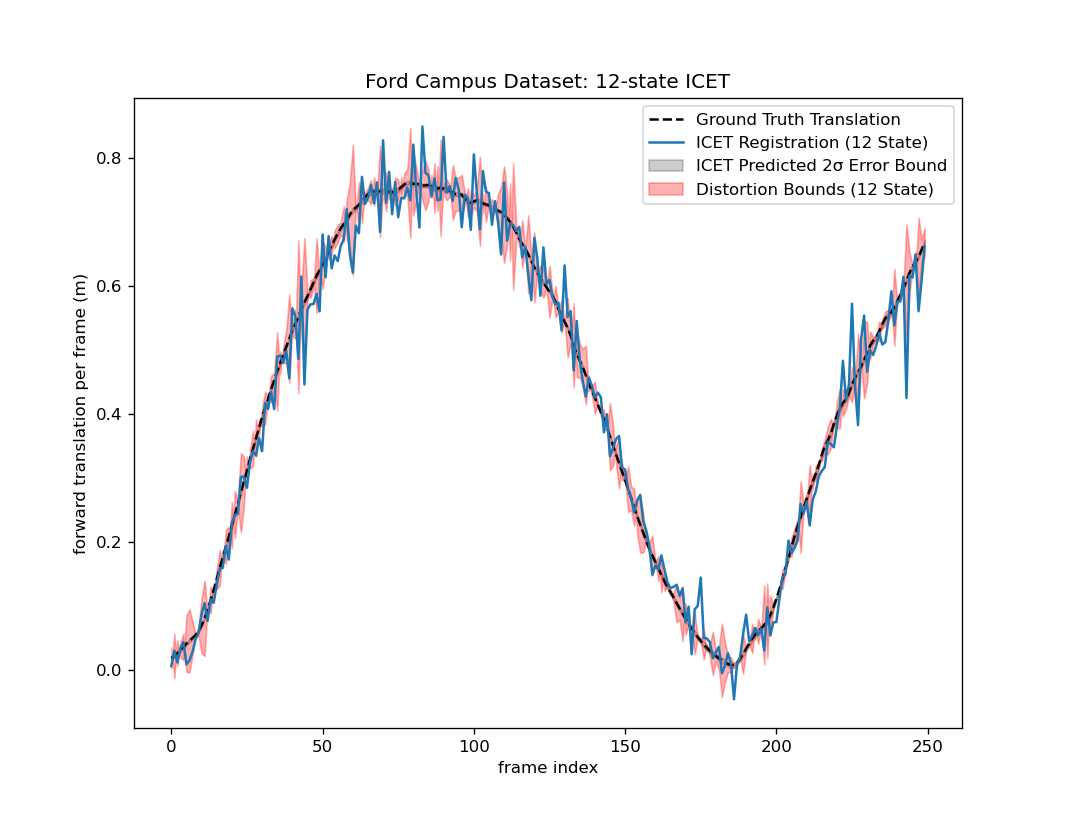

In [233]:
#plot updated bounds
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #v5

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

ax.plot(X_hat_history[:,0], label = "ICET Registration (12 State)")

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
                   color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')
ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [234]:
# np.save("sample_data/Ford_m_hat_history_12_state_ICET_990",  m_hat_history)
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_990",  m_hat_history)

### DEBUG: run Vanilla ICET on Ford dataset and compare convergence with similar parameters 